# **Beats Classifiers on PPG signal**
Applied AI in Biomedicine - Final Assignment

Edoardo Eula [10684820]

Frederik Heinzel [10920756]

Michele Masserini [10705823]

##**1** Introduction

In the provided notebook, two classifiers were created to analyze PPG signals from 105 patients. The primary objective of the first classifier is to distinguish between abnormal and normal beats. Meanwhile, the second classifier is designed to categorize abnormal beats into subtypes, specifically distinguishing between superventricular, ventricular, or normal beats.

### **1.1** Set up the environment

In [ ]:
import os
import numpy as np, os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import seaborn as sns
import random
import sklearn
import random

import scipy
from scipy.io import loadmat
from random import randint

import tensorflow as tf
tfk = tf.keras
tfkl = tfk.layers

import sklearn
from sklearn.model_selection import train_test_split

SEED = 69
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

print("Using Tensorflow version",tf.__version__)
print("RNG seed:", SEED)

color = {
    "signal": "#073b4c",
    "N": "#94C9A9",
    "S": "#E49273",
    "V": "#8BE8CB",
    "p": "#494947",
}

from scipy.signal import butter, filtfilt
from scipy.fft import fft

#Ignore warnings
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

# Your code generating warnings

# Reset warnings to default behavior (optional)
warnings.resetwarnings()

Using Tensorflow version 2.15.0
RNG seed: 69


In [ ]:
from google.colab import drive
drive.mount('/gdrive')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Mounted at /gdrive


### **1.2** Data Extraction

To extract data, a class named `Patient` has been defined to encapsulate relevant functions for handling PPG signal data. Here's a brief explanation of the class and its methods:

- **Initialization (`__init__`):**
  - The class is initialized with a dictionary (`init_dict`) containing essential information about the patient, such as the file path (`path`), sampling frequency (`fs`), patient ID (`ID`), PPG signal (`ppg`), peak labels (`peak_labels`), and other relevant details.
  - The time array (`time`) is generated based on the sampling frequency and the number of samples.
  - If the sampling frequency is not 128 Hz, the signal is interpolated to match the desired frequency. This involves adjusting the time array, signal, and peak labels accordingly.

- **Information Display (`info`):**
  - Prints various details about the patient, including ID, file path, sampling frequency, number of samples, PPG signal, peak labels, etc.

- **Plotting (`plot`):**
  - Plots the PPG signal along with annotated peaks for different beat types (Normal, Superventricular, Ventricular).
  - An optional window start parameter allows plotting a specific window of the signal.

- **Peak Splitting (`split_peaks`):**
  - Splits the PPG signal into windows based on peak locations.
  - The `borders` parameter controls the percentage of the peak used as a border.
  - Optionally, windows can be adjusted to have a fixed length.

- **MA Detection (`detectMA`):**
  - Detects the number of points in the signal exceeding a specified amplitude (`detAmp`).

- **Patient Removal (`dropPatient`):**
  - Removes a patient from the list of patients based on the given index (`pcount`).

- **NaN Count (`countnans`):**
  - Counts the number of NaN values in the PPG signal.

- **Peak Label Check (`detectOnlyN`):**
  - Checks if all peak labels in the signal belong to the 'N' (Normal) category.

This class provides a convenient and organized way to handle PPG signal data for further analysis and processing.

In [ ]:
class Patient:
    def __init__(self, init_dict):
        self.path = init_dict['path']
        self.fs = init_dict['fs']
        self.id = init_dict['ID']
        self.speaks = init_dict['speaks']
        self.peaklabels = init_dict['peak_labels']
        self.signal = init_dict['ppg']
        self.samples = init_dict['samples']
        self.time = np.arange(0, self.samples / self.fs, 1 / self.fs)

        if self.fs != 128:
            f_signal = scipy.interpolate.interp1d(self.time, self.signal)
            self.time = np.arange(0, self.samples / self.fs, 1 / self.fs)
            self.signal = f_signal(self.time)
            self.speaks = np.round(self.speaks * 128 / self.fs).astype('int')
            self.fs = 128.0

    def info(self):
        print(">> ID:", self.id)
        print(" | path:", self.path)
        print(" | fs:", self.fs)
        print(" | samples:", self.samples)
        print(" | ppg:", self.signal)
        print(" | speaks:", self.speaks)
        print(" | peak_labels:", self.peaklabels)

    def plot(self, windowstart=0, xrange=4000):
        # Create a new figure and axis
        fig, ax = plt.subplots(figsize=(10, 5))

        # Plot the signal
        ax.plot(self.time, self.signal, color=color['signal'])

        # Scatter plot for different peak labels
        ax.scatter(self.speaks[self.peaklabels == 'N'] / self.fs,
                    self.signal[self.speaks[self.peaklabels == 'N']],
                    color=color['N'], s=50, alpha=0.5, label="Normal")
        ax.scatter(self.speaks[self.peaklabels == 'S'] / self.fs,
                    self.signal[self.speaks[self.peaklabels == 'S']],
                    color=color['S'], s=50, alpha=0.5, label="SopraVentricular")
        ax.scatter(self.speaks[self.peaklabels == 'V'] / self.fs,
                    self.signal[self.speaks[self.peaklabels == 'V']],
                    color=color['V'], s=50, alpha=0.5, label="Ventricular")

        # Customize plot
        ax.grid(True)
        ax.set_xlim([windowstart / self.fs, (windowstart + xrange) / self.fs])
        ax.set_ylim([-40, 40])
        ax.set_title(f"Patient #{self.id} - PPG signal")
        ax.set_xlabel("Time [seconds]")

        # Display legend
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)

        # Show the plot
        plt.show()

    def split_peaks(self, borders=0.05, fixed_length=False):
        border_samples = round(borders * (self.speaks[0]))

        windows = [self.signal[0:(self.speaks[0] - border_samples)]]

        for p in range(1, self.speaks.shape[0] - 1):
            border_samples = round(borders * (self.speaks[p + 1] - self.speaks[p - 1]))
            window = self.signal[(self.speaks[p - 1] + border_samples):(self.speaks[p + 1] - border_samples)]
            windows.append(window)

        border_samples = round(borders * (self.speaks[0]))
        windows.append(self.signal[self.speaks[-1]:self.samples])

        if fixed_length != False:
            r = []
            for i,w in enumerate(windows):
                if w.shape[0] >= fixed_length:
                    r.append(
                        w[w.shape[0]//2-fixed_length//2:w.shape[0]//2+(fixed_length-fixed_length//2)]
                    )
                elif w.shape[0] < fixed_length:
                    pad_left = (fixed_length - w.shape[0]) // 2
                    pad_right = fixed_length - pad_left - w.shape[0]
                    r.append(
                        np.pad(windows[i], (pad_left, pad_right), mode='edge')
                    )
            windows = r
        return windows

    def check_amplitude_variation(self):
      amplitude_variation = np.std(self.signal)
      return amplitude_variation

    def z_score_normalize_signal(self):
      """
      Applies z-score normalization to the signal data.

      Parameters:
      None

      Returns:
      None
      """
      self.signal = (self.signal - np.mean(self.signal)) / np.std(self.signal)


    def butter_bandpassfilter(self, lowcut, highcut, fs, order=4):
      nyquist = 0.5 * fs
      low = lowcut / nyquist
      high = highcut / nyquist
      b, a = butter(order, [low, high], btype='band')
      self.signal = filtfilt(b, a, self.signal)

    def dropPatient(self, patients, pcount):
        if 0 <= pcount < len(patients):
            patients.pop(pcount)
        else:
            print(f"Invalid index: {pcount}")

    def countnans(self):
        return np.count_nonzero(np.isnan(self.signal))

    def detectOnlyN(self):
            if np.all(self.peaklabels == 'N'):
                return 1
            else:
                return 0


###**1.3** Data Loading

In [ ]:
dataset_path = '/gdrive/MyDrive/AI_project/train'

In [ ]:
files = sorted(os.listdir(dataset_path))
print(files)

['S001_128.mat', 'S001_128_ann.mat', 'S001_128_spk.mat', 'S002_128.mat', 'S002_128_ann.mat', 'S002_128_spk.mat', 'S003_128.mat', 'S003_128_ann.mat', 'S003_128_spk.mat', 'S004_128.mat', 'S004_128_ann.mat', 'S004_128_spk.mat', 'S005_128.mat', 'S005_128_ann.mat', 'S005_128_spk.mat', 'S006_128.mat', 'S006_128_ann.mat', 'S006_128_spk.mat', 'S007_128.mat', 'S007_128_ann.mat', 'S007_128_spk.mat', 'S008_128.mat', 'S008_128_ann.mat', 'S008_128_spk.mat', 'S009_128.mat', 'S009_128_ann.mat', 'S009_128_spk.mat', 'S010_128.mat', 'S010_128_ann.mat', 'S010_128_spk.mat', 'S011_128.mat', 'S011_128_ann.mat', 'S011_128_spk.mat', 'S012_128.mat', 'S012_128_ann.mat', 'S012_128_spk.mat', 'S013_128.mat', 'S013_128_ann.mat', 'S013_128_spk.mat', 'S014_128.mat', 'S014_128_ann.mat', 'S014_128_spk.mat', 'S015_128.mat', 'S015_128_ann.mat', 'S015_128_spk.mat', 'S016_128.mat', 'S016_128_ann.mat', 'S016_128_spk.mat', 'S017_128.mat', 'S017_128_ann.mat', 'S017_128_spk.mat', 'S018_128.mat', 'S018_128_ann.mat', 'S018_128_s

In [ ]:
correct = 0
incorrect = 0
nans = 0

patient = []

for f in range(0,len(files),3):
  try:
    ppg = loadmat(os.path.join(dataset_path,files[f]))
    ann = loadmat(os.path.join(dataset_path,files[f+1]))
    spk = loadmat(os.path.join(dataset_path,files[f+2]))
    patient_dict={
            'ID':files[f].split("_")[0],
            'path':os.path.join("train",files[f]),
            'fs':float(files[f].split(".")[0].split("_")[1]),
            'samples':ppg['ppg'][:,0].shape[0],
            'ppg':ppg['ppg'][:,0],
            'speaks':spk['speaks'].T[0], #speaks vector transpose
            'peak_labels':ann['labels']
    }
    patient.append(Patient(patient_dict))
    nans += patient[-1].countnans()
    correct+=1
  except:
    incorrect +=1

print(f"Loaded {correct} files correctly")
if incorrect>0: print(f"!!!! Error in loading {incorrect} files")
if nans>0: print("Found: ",nans, "missing values")

Loaded 105 files correctly


## **2** Preprocessing

Let's firstly inspect the signals we loaded by plotting them together with their labels.

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


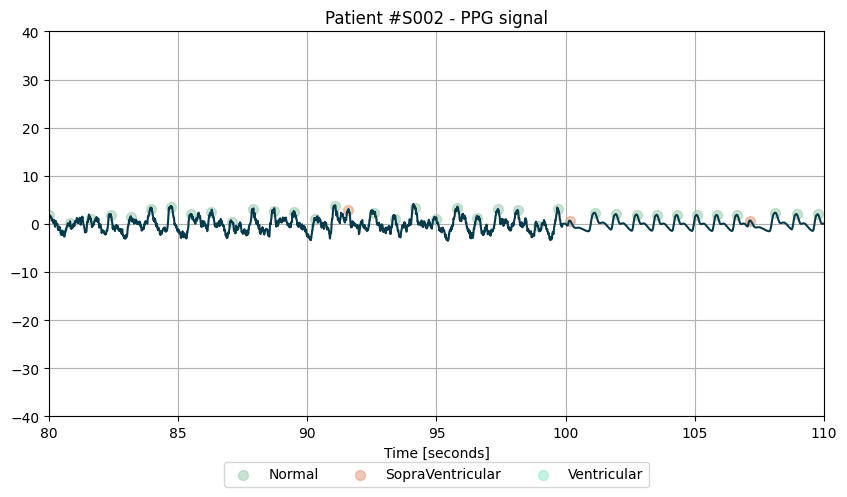

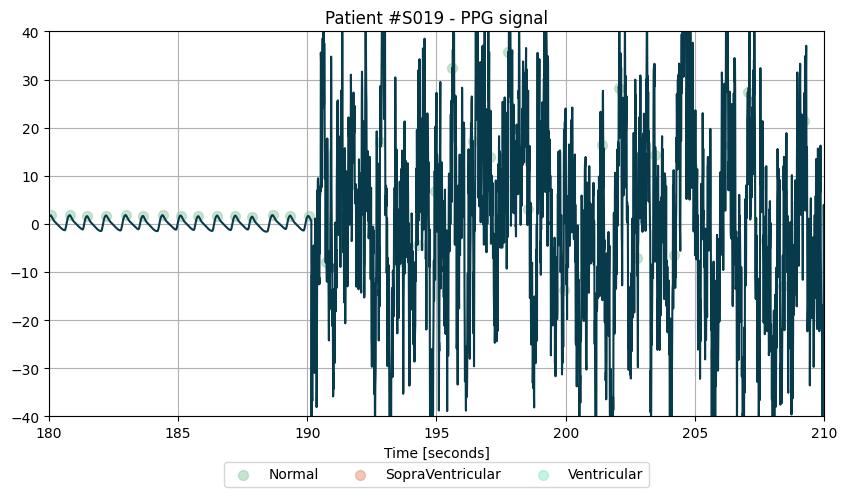

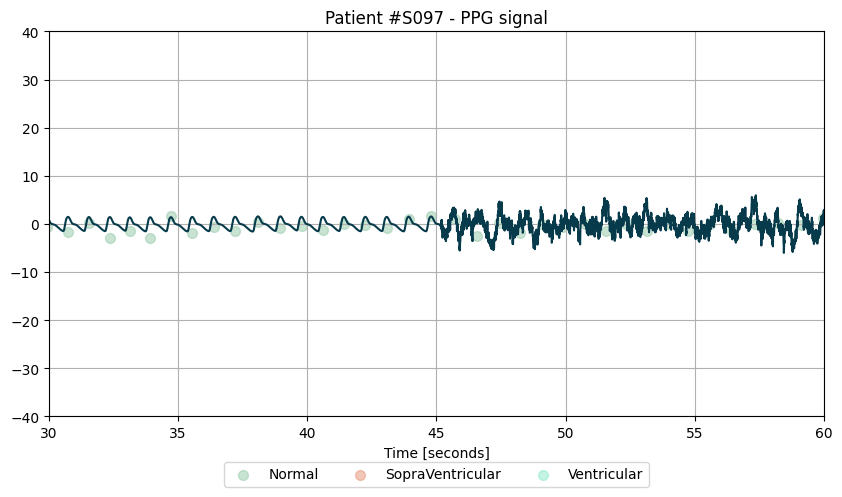

In [ ]:
patient[1].plot(80*patient[1].fs, 30*patient[1].fs)
patient[18].plot(180*patient[18].fs, 30*patient[18].fs)
patient[80].plot(30*patient[99].fs, 30*patient[99].fs)

### **2.1** Amplitude variations

In order to provide our models just good signals we check for high amplitude variations.

In [ ]:
amp_var = []
for i in range(len(patient)):
  k = patient[i].check_amplitude_variation()
  amp_var.append(k)

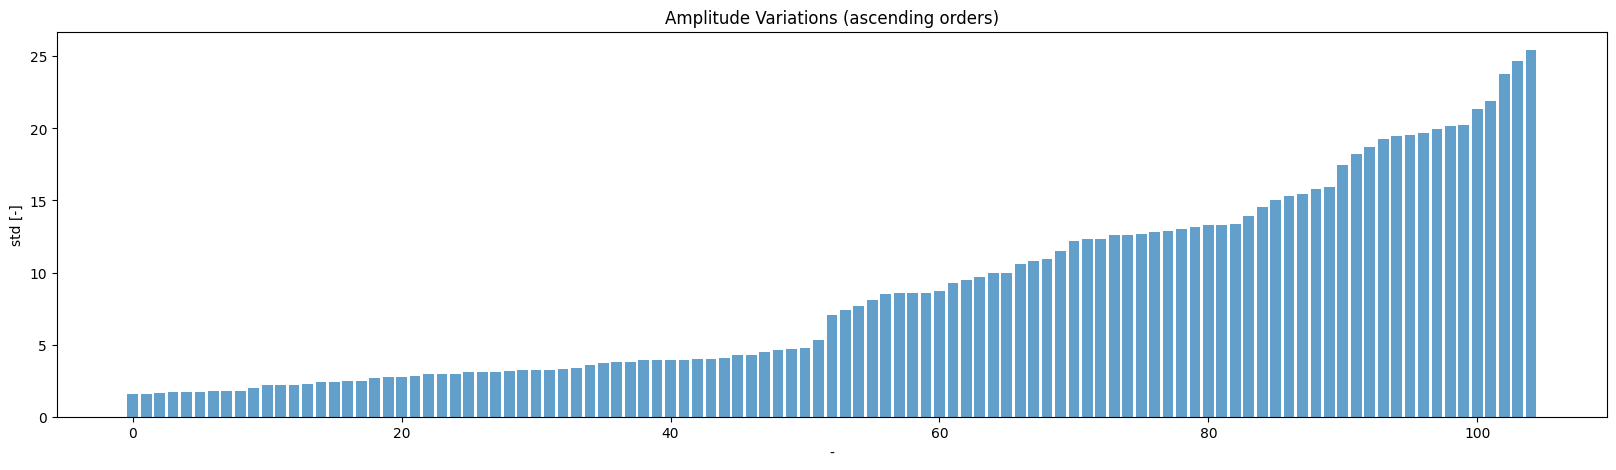

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

sorted_amp = np.sort(amp_var)

# Create an array for x-axis ticks
x_ticks = np.arange(len(sorted_amp))

fig = plt.figure(figsize=(20, 5))
# Plot the bar chart
plt.bar(x_ticks, sorted_amp, align='center', alpha=0.7)
plt.xlabel('-')
plt.ylabel('std [-]')
plt.title('Amplitude Variations (ascending orders)')
plt.show()

We are going to remove signals with an std higher than 10.

In [ ]:
pat_to_remove = []
j = 0
for i in range(len(patient)):
  k = patient[i].check_amplitude_variation()
  if (k > 10):
    pat_to_remove.append(i-j)
    j+=1

In [ ]:
for i in range(len(pat_to_remove)):
  patient[pat_to_remove[i]].dropPatient(patient, pat_to_remove[i])

### **2.2** Normal beats cleaning

Given our objective to develop classifiers capable of identifying abnormal beats, we have chosen to exclude patients who solely exhibit normal beats. This decision is motivated not only by the oversampling of the normal beats class, which could potentially bias the classifiers, but also aligns with our focus on abnormal beat detection.

In [ ]:
pat_to_remove = []
j = 0
for i in range(len(patient)):
  k = patient[i].detectOnlyN()
  if (k == 1):
    pat_to_remove.append(i-j)
    j+=1

print("Patients' ID which contains only N beats")
pat_to_remove

Patients' ID which contains only N beats


[44, 46, 52, 52, 52, 56, 59]

In [ ]:
for i in range(len(pat_to_remove)):
  patient[pat_to_remove[i]].dropPatient(patient, pat_to_remove[i])

In [ ]:
print("Number of patients after cleaning: {}".format(len(patient)))

Number of patients after cleaning: 59


### **2.3** Inspect data

We wanted to consider two aspects:
- the length of the beats to coherently make windows of the signals we have
- the distance between abnormal beats, since usually abnormal beats influence following beats

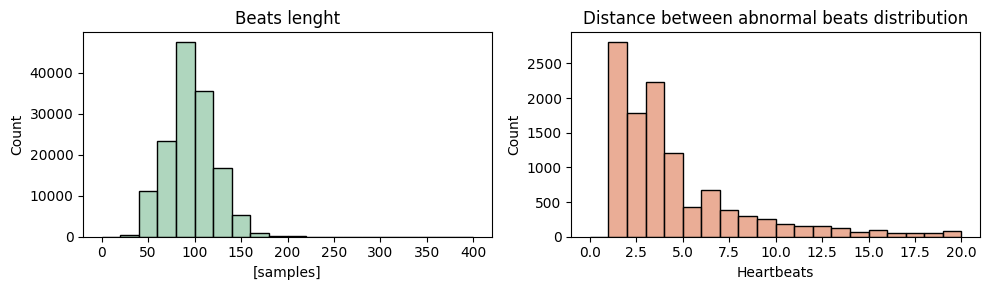

In [ ]:
ints = []
wins = []
N_count = 0
S_count = 0
V_count = 0

for ptest in patient:
    nn = np.where(np.logical_or(ptest.peaklabels=='V',ptest.peaklabels=='S'))
    intervals = np.diff(nn)[0]
    wins.append(np.diff(ptest.speaks))
    ints.append(intervals)
    N_count+=np.count_nonzero(ptest.peaklabels=='N')
    S_count+=np.count_nonzero(ptest.peaklabels=='S')
    V_count+=np.count_nonzero(ptest.peaklabels=='V')

intervals = np.concatenate(ints,axis=0)
sys_peaks_win = np.concatenate(wins,axis=0)

plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
sns.histplot(sys_peaks_win,bins=20,binrange=[0,400], color = color['N'])
plt.xlabel("[samples]")
plt.title("Beats lenght")
plt.subplot(1,2,2)
sns.histplot(intervals,bins=20,binrange=[0,20], color = color['S'])
plt.xlabel("Heartbeats")
plt.title("Distance between abnormal beats distribution")
plt.subplots_adjust(wspace=0.4)
plt.tight_layout()
plt.show()

The barplot on the right confirm that abnormal beats are usually near.

Regarding splitting windows, our method consists on splitting each single beat padding the window to a defined length; we chose as length 200, since from the graph in the left is shown that is the highest length.

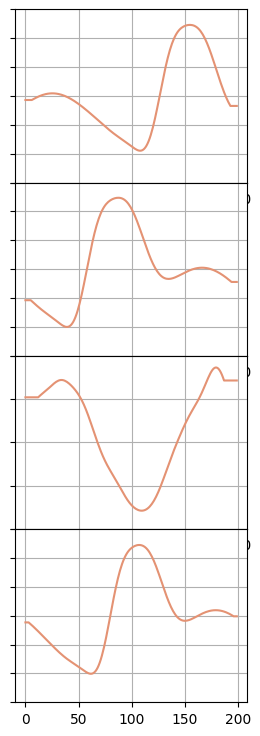

In [ ]:
split = ptest.split_peaks(borders=0.05, fixed_length=200)
idxs = [randint(0,1000) for _ in range(4)]
plt.figure(figsize=(3,9))
for p,i in enumerate(idxs):
    plt.subplot(4,1,p+1)
    plt.plot(split[i],color=color['S'])
    # plt.title(f"W{i}: length={len(split1[i])}")
    yt,_ = plt.yticks()
    plt.yticks(ticks=yt,labels=[])
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.grid(True)
plt.show()

Finally, we assess the imbalance within our classes, observing a significant overrepresentation of normal beats in our dataset.

In [ ]:
N,S,V = 0,0,0
X=0
l=0
for p in patient:
    l+=p.peaklabels.shape[0]
    N+=np.count_nonzero(p.peaklabels=='N')
    S+=np.count_nonzero(p.peaklabels=='S')
    V+=np.count_nonzero(p.peaklabels=='V')
print("NUMBER OF BEATS: Normal: ",N,"- Sopraventricular: ",S,"- Ventricular:",V)
print("PERCENTAGE: Normal: ",N/(N+S+V),"- Sopraventricular: ",S/(N+S+V),"- Ventricular:",V/(N+S+V),)

NUMBER OF BEATS: Normal:  129807 - Sopraventricular:  6736 - Ventricular: 5080
PERCENTAGE: Normal:  0.9165672242502984 - Sopraventricular:  0.04756289585731131 - Ventricular: 0.03586987989239036


### **2.4** Filtering

Here we are setting the frequency to be between 0.5Hz and 5Hz with a 3rd order Butterworth filter.

In [ ]:
fs = 128
lowcut = 0.5
highcut = 5.0

for p in patient:
  p.butter_bandpassfilter(lowcut, highcut, fs, 3)

### **2.5** Data normalization

In [ ]:
for p in patient:
  p.z_score_normalize_signal()

## **3** Models

### **3.1** Detect between normal and abnormal beats

Firstly we build our dataset introducing also a "past" label which allows us to keep track of when an abnormal beat happens. We will use this "past" labels, together with a label for normal, [1,0,0], and one for abnormal beats, [0,1,0].

In [ ]:
categorical = {'N':np.array([1,0,0]),'S':np.array([0,1,0]),'V':np.array([0,1,0]), 'p':np.array([0,0,1])}

In [ ]:
N_to_take = round((V+S) / len(patient))

def build_dataset(patients, width=200):
    X_Win = []
    X_Past = []
    Y = []
    patient_ID = []
    for p in patients:
        split = p.split_peaks(borders=0.05, fixed_length=width)
        vect = np.arange(0, len(split))
        np.random.shuffle(vect)
        N = 0
        for i in vect:
            if p.peaklabels[i] != 'N':
                X_Win.append(np.array(split[i]))
                Y.append(categorical[p.peaklabels[i]])

                if i >= 2:
                    X_Past.append(np.array([categorical[p.peaklabels[i-2]], categorical[p.peaklabels[i-1]]]))
                elif i == 1:
                    X_Past.append(np.array([categorical['p'], categorical[p.peaklabels[i-1]]]))
                else:
                    X_Past.append(np.array([categorical['p'], categorical['p']]))

            if p.peaklabels[i] == 'N' and N < N_to_take:
                X_Win.append(np.array(split[i]))
                n_pat = p.id
                patient_ID.append(n_pat)
                Y.append(categorical[p.peaklabels[i]])

                if i >= 2:
                    X_Past.append(np.array([categorical[p.peaklabels[i-2]], categorical[p.peaklabels[i-1]]]))
                elif i == 1:
                    X_Past.append(np.array([categorical['p'], categorical[p.peaklabels[i-1]]]))
                else:
                    X_Past.append(np.array([categorical['p'], categorical['p']]))

                N = N + 1

    return (np.stack(X_Win, axis=0), np.stack(X_Past, axis=0)), np.stack(Y, axis=0), np.stack(patient_ID, axis=0)

(X_W, X_P), Y, patient_ID = build_dataset(patient, 200)

print(f"INPUT WINDOW shape: {X_W.shape} as (WINDOW, TIME)")
print(f"INPUT PAST shape: {X_P.shape} as (WINDOW, PAST, one-hot-LABEL)")
print(f"OUTPUT shape: {Y.shape} as (WINDOW, one-hot-LABEL)")

INPUT WINDOW shape: (23616, 200) as (WINDOW, TIME)
INPUT PAST shape: (23616, 2, 3) as (WINDOW, PAST, one-hot-LABEL)
OUTPUT shape: (23616, 3) as (WINDOW, one-hot-LABEL)


#### Train-test splitting

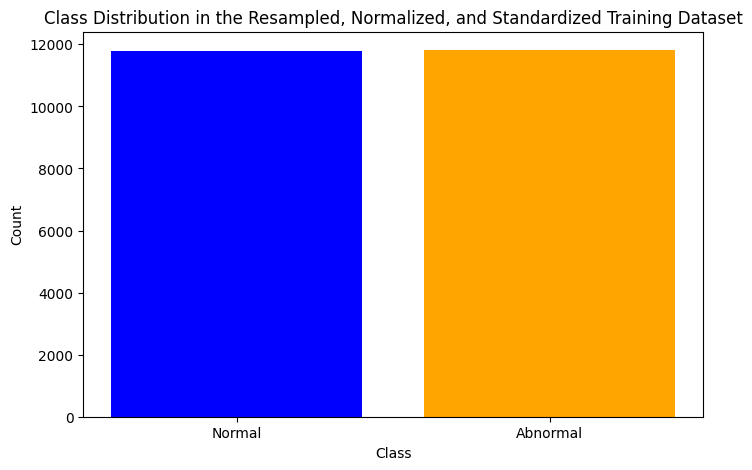

In [ ]:
from sklearn.model_selection import train_test_split

# Split into training and validation sets
XtrainW, XvalW, XtrainP, XvalP, Ytrain, Yval = train_test_split(
    X_W, X_P, Y,
    test_size=0.3, shuffle=True, stratify=Y
)

# Split into validation and test sets
XvalW, XtestW, XvalP, XtestP, Yval, Ytest = train_test_split(
    XvalW, XvalP, Yval,
    test_size=0.3, shuffle=True, stratify=Yval
)


# Plot barplots for the resampled and standardized dataset
plt.figure(figsize=(8, 5))
plt.bar(['Normal', 'Abnormal'], np.bincount(np.argmax(Y, axis=1)), color=['blue', 'orange'])
plt.title('Class Distribution in the Resampled, Normalized, and Standardized Training Dataset')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


#### Mean and standard deviation

In [ ]:
# Concatenate all windows in XtrainW
XtrainW_all = np.concatenate(XtrainW, axis=0)
XtrainW_all.shape

# Calculate mean and standard deviation for each feature
signal_mean, signal_std = np.mean(XtrainW_all, axis=0), np.std(XtrainW_all, axis=0)
print(f"Signal: mean = {signal_mean} std = {signal_std}")

Signal: mean = 0.03249887688136163 std = 0.9919799488302121


#### Time domain model

##### Time Model Architecture and Training

We designed this model to process time-series data with two distinct input streams: `InputWin` and `InputPast`. The model consists of convolutional and recurrent layers followed by dense layers for classification

##### Inputs

- `InputWin`: Input for the current window of time-series data.
- `InputPast`: Input for the past data.

##### Layers

1. **Input Layer**:
    - `InputWin`: Shape defined by `inputwin_shape`.
    - `InputPast`: Shape defined by `inputpast_shape`.

2. **Preprocessing**:
    - `Reshape`: Reshapes the `InputWin` to add a time_steps dimension.

3. **Convolutional and Recurrent Layers**:
    - `LSTM`: Recurrent layer with 256 units.
    - `Conv1D`: Convolutional layers with 128 filters and kernel size of 5.
    - `BatchNormalization`: Normalizes the activations.
    - `Activation`: ReLU activation function.
    - `MaxPooling1D`: Max pooling layer with pool size of 2.
    - `Dropout`: Dropout regularization with a rate of 0.5.

4. **Flatten and Dense Layers**:
    - `Flatten`: Flattens the input.
    - `Dense`: Fully connected layers with 512 and 3 units respectively, using ReLU and softmax activations.

5. **Concatenation**:
    - `Concatenate`: Concatenates the flattened output with `InputPast`.

6. **Output Layer**:
    - `Dense`: Output layer with a softmax activation function for classification into `classes` categories.



Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 InputWin (InputLayer)       [(None, 200)]                0         []                            
                                                                                                  
 reshape_20 (Reshape)        (None, 200, 1)               0         ['InputWin[0][0]']            
                                                                                                  
 lstm_19 (LSTM)              (None, 200, 256)             264192    ['reshape_20[0][0]']          
                                                                                                  
 conv1d_62 (Conv1D)          (None, 200, 128)             163968    ['lstm_19[0][0]']             
                                                                                            

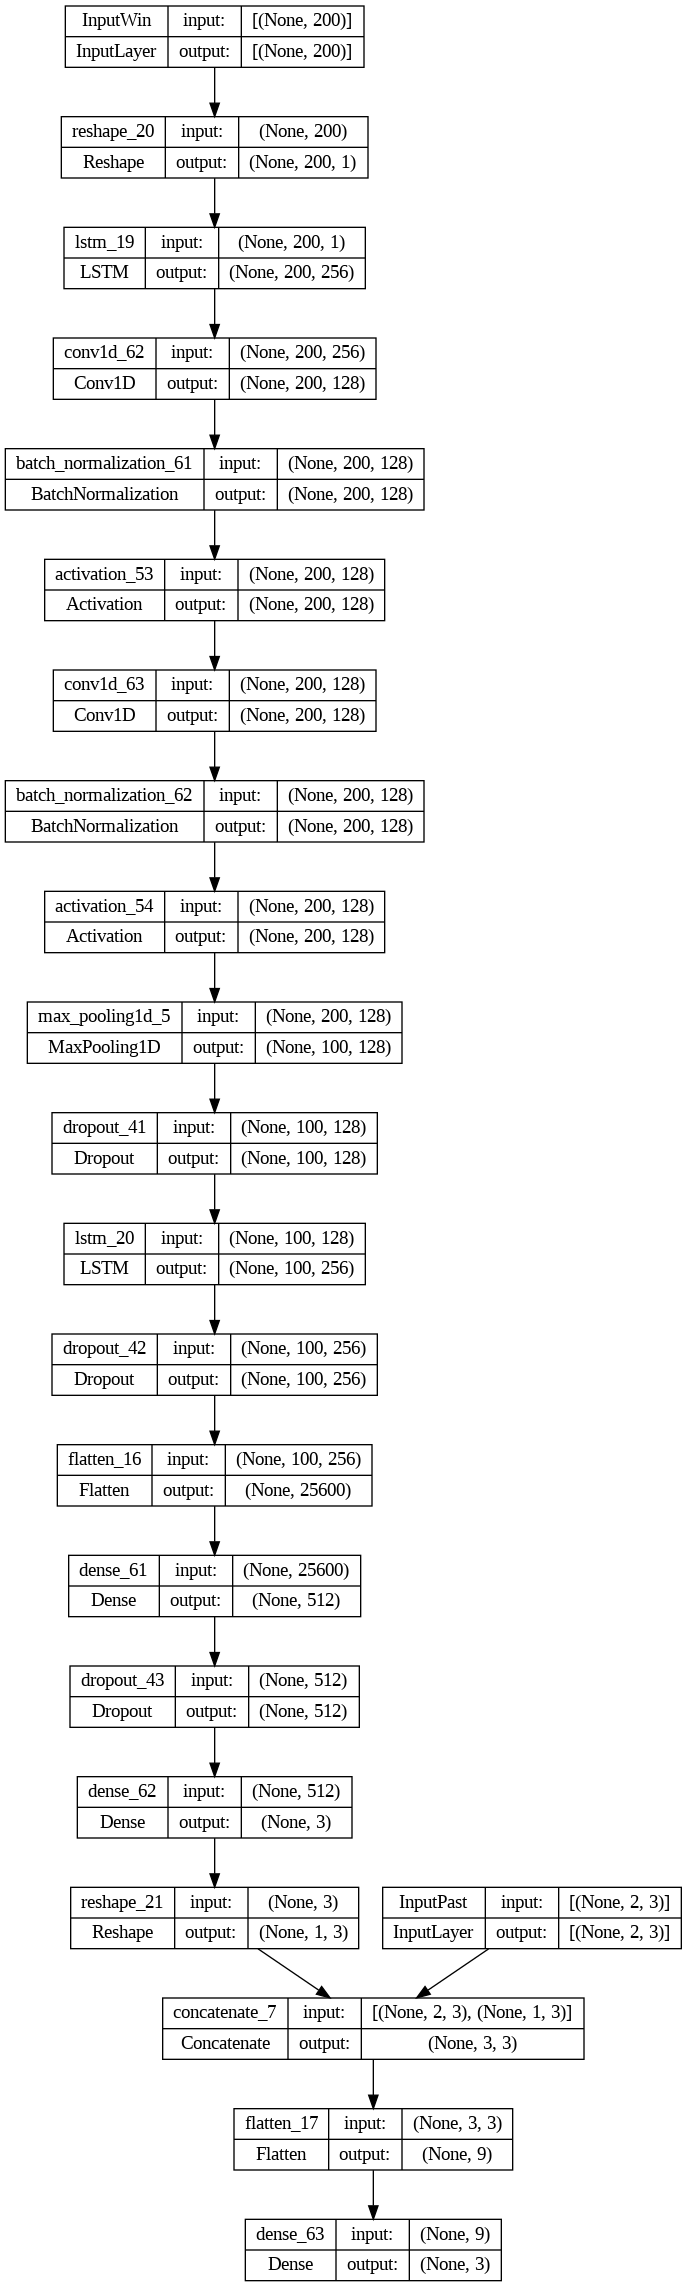

In [ ]:
import tensorflow.keras.layers as tfkl
import tensorflow as tf

def build_time_model(inputwin_shape, inputpast_shape, classes):
    inputwin_layer = tfkl.Input(shape=inputwin_shape, name='InputWin')
    inputpast_layer = tfkl.Input(shape=inputpast_shape, name='InputPast')

    # Reshape inputwin_layer to add the time_steps dimension
    x = tfkl.Reshape((inputwin_shape[0], 1))(inputwin_layer)

    # Initial convolutional layer
    x = tfkl.LSTM(256, return_sequences=True)(x)
    x = tfkl.Conv1D(filters=128, kernel_size=5, padding='same')(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Activation('relu')(x)
    x = tfkl.Conv1D(filters=128, kernel_size=5, padding='same')(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Activation('relu')(x)
    x = tfkl.MaxPooling1D(pool_size=2)(x)
    x = tfkl.Dropout(0.5)(x)

    x = tfkl.LSTM(256, return_sequences=True)(x)
    x = tfkl.Dropout(0.5)(x)

    # Flatten and dense layers
    x = tfkl.Flatten()(x)
    x = tfkl.Dense(512, activation='relu')(x)
    x = tfkl.Dropout(0.5)(x)
    x = tfkl.Dense(3, activation='relu')(x)

    # Concatenate with inputpast_layer
    x2 = tfkl.Reshape((1, 3))(x)
    xc = tfkl.Concatenate(axis=1)([inputpast_layer, x2])
    x = tfkl.Flatten()(xc)

    # Output layer with softmax activation
    output_layer = tfkl.Dense(classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=[inputwin_layer, inputpast_layer], outputs=output_layer)
    return model

# Assuming XtrainW[0] and XtrainP[0] are your training data
timemodel = build_time_model(inputwin_shape=XtrainW[0].shape, inputpast_shape=XtrainP[0].shape, classes=3)
timemodel.summary()
tf.keras.utils.plot_model(timemodel, show_shapes=True)


In [ ]:
BATCH_SIZE = 128
EPOCHS = 1000
LEARNING_RATE = 1e-3

timemodel.compile(
    loss=tfk.losses.CategoricalCrossentropy(),
    optimizer=tfk.optimizers.Adam(learning_rate=LEARNING_RATE),
    metrics= 'accuracy'
)

# Define your learning rate schedule function
def lr_schedule(epoch, lr):
    if epoch < 10:
        return lr  # Use the initial learning rate for the first 10 epochs
    else:
        return lr * tf.math.exp(-0.1)  # Decay the learning rate exponentially

# Create a LearningRateScheduler callback
lr_scheduler = tfk.callbacks.LearningRateScheduler(lr_schedule)

# Add the LR callback to the list of callbacks
callbacks_list = [
    tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20),
    lr_scheduler
]

history = timemodel.fit(
    x=[XtrainW, XtrainP],
    y=Ytrain,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=([XvalW, XvalP], Yval),
    callbacks=callbacks_list
).history


Epoch 1/1000
130/130 [==============================] - 15s 78ms/step - loss: 0.7895 - accuracy: 0.6681 - val_loss: 0.6723 - val_accuracy: 0.7360 - lr: 0.0010
Epoch 2/1000
130/130 [==============================] - 8s 65ms/step - loss: 0.5656 - accuracy: 0.7719 - val_loss: 0.5038 - val_accuracy: 0.7875 - lr: 0.0010
Epoch 3/1000
130/130 [==============================] - 9s 70ms/step - loss: 0.4754 - accuracy: 0.8070 - val_loss: 0.4347 - val_accuracy: 0.8238 - lr: 0.0010
Epoch 4/1000
130/130 [==============================] - 9s 69ms/step - loss: 0.4304 - accuracy: 0.8186 - val_loss: 0.4032 - val_accuracy: 0.8365 - lr: 0.0010
Epoch 5/1000
130/130 [==============================] - 9s 66ms/step - loss: 0.3998 - accuracy: 0.8323 - val_loss: 0.3815 - val_accuracy: 0.8397 - lr: 0.0010
Epoch 6/1000
130/130 [==============================] - 9s 72ms/step - loss: 0.3833 - accuracy: 0.8421 - val_loss: 0.3651 - val_accuracy: 0.8463 - lr: 0.0010
Epoch 7/1000
130/130 [=============================

TRAINING HISTORY


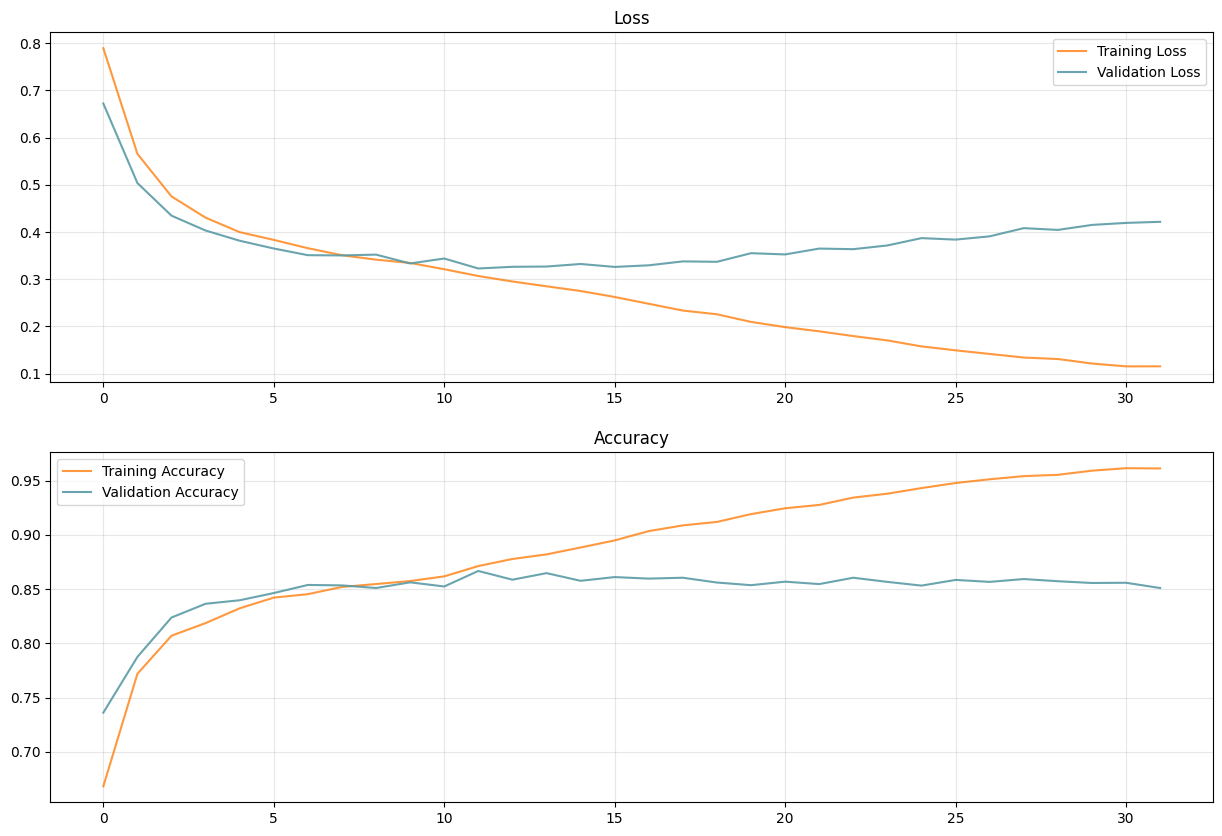

In [ ]:
print("TRAINING HISTORY")
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
plt.plot(history['loss'], label='Training Loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation Loss', alpha=.9, color='#5a9aa5')
plt.title('Loss')
plt.legend()
plt.grid(alpha=.3)
plt.subplot(2, 1, 2)
plt.plot(history['accuracy'], label='Training Accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation Accuracy', alpha=.9, color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
preds = np.argmax(timemodel.predict([XtestW, XtestP]), axis=1)
Ytestt = np.argmax(Ytest, axis=1)
corrects = preds == Ytestt
print("ACCURACY:", np.count_nonzero(corrects) / corrects.shape[0])

67/67 [==============================] - 1s 10ms/step
ACCURACY: 0.8551269990592663


CONFUSION MATRIX
[[897 165]
 [143 921]]


              precision    recall  f1-score   support

           0       0.86      0.84      0.85      1062
           1       0.85      0.87      0.86      1064

    accuracy                           0.86      2126
   macro avg       0.86      0.86      0.86      2126
weighted avg       0.86      0.86      0.86      2126



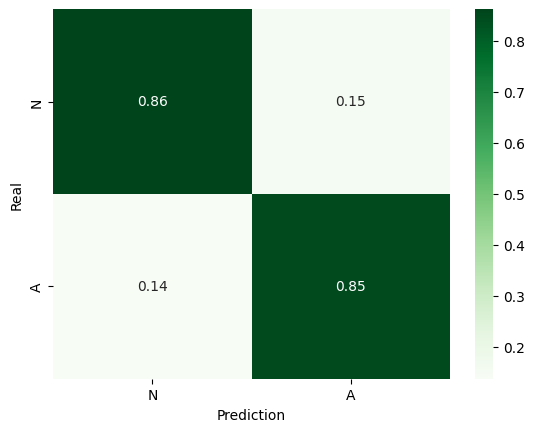

In [ ]:
print("CONFUSION MATRIX")
print(sklearn.metrics.confusion_matrix(Ytestt, preds))
print()
print()
print(sklearn.metrics.classification_report(Ytestt, preds))

cmt = sklearn.metrics.confusion_matrix(Ytestt, preds) / np.sum(sklearn.metrics.confusion_matrix(Ytestt, preds), axis=0)
hm = sns.heatmap(cmt, annot=True, fmt=".2f", cmap="Greens")
hm.set_xticklabels(['N', 'A'])
hm.set_xlabel("Prediction")
hm.set_ylabel("Real")
hm.set_yticklabels(['N', 'A'])
plt.show()

In [ ]:
import os
from datetime import datetime
from tensorflow.keras.models import save_model

# Save the model
time_stamp = datetime.now().strftime("%Y%m%d_%H%M")
timemodel_folder = '/gdrive/MyDrive/AI_project/models/time_models'
timemodel_name = f"time_model_{time_stamp}_newPreprocessing_undersampling2"  # Add additional info if needed

# Assuming timemodel is your model
save_model(timemodel, os.path.join(timemodel_folder, f"{timemodel_name}.h5"))

<ipython-input-74-10cff3b4911b>:11: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(timemodel, os.path.join(timemodel_folder, f"{timemodel_name}.h5"))


#### Frequency Domain Model

In [ ]:
fXtrainW = np.fft.fft(XtrainW, axis=1)
fXvalW = np.fft.fft(XvalW, axis=1)
fXtestW = np.fft.fft(XtestW, axis=1)
fYtrain = Ytrain
fYval = Yval
fYtest = Ytest
fXtrainP = XtrainP
fXvalP = XvalP
fXtestP = XtestP

##### Frequency Model Architecture Overview and Training

We designed this model to process time-series data with two distinct input streams: `InputWin` and `InputPast`. The model incorporates a ResNet-like structure with Squeeze and Excitation (SE) blocks and self-attention mechanisms to capture both spatial and temporal dependencies in the data.

###### Architecture Details

###### Squeeze and Excitation (SE) Block

The SE block enhances channel-wise feature attention by learning adaptive weights for each channel.

###### ResNet Block with SE and Attention

Two types of ResNet blocks are used:
1. **Identity Blocks**: Consist of convolutional layers, batch normalization, SE blocks, and self-attention.
2. **Convolution Blocks**: Similar to identity blocks but with an initial convolutional layer and a residual connection.

###### Layers

1. **Input Layers**:
    - `InputWin`: Input for the current window of time-series data.
    - `InputPast`: Input for the past data.

2. **Preprocessing**:
    - `Reshape`: Reshapes the `InputWin` to add a time_steps dimension.

3. **ResNet Blocks**:
    - `ResBs_SE_Identity_with_attention`: Identity blocks with SE and attention.
    - `ResBs_SE_Conv_with_attention`: Convolution blocks with SE and attention.

4. **LSTM Layers**:
    - `LSTM`: Recurrent layers to capture long-term dependencies in the data.

5. **Flatten and Dense Layers**:
    - `Flatten`: Flattens the input.
    - `Dense`: Fully connected layers for classification with ReLU activation.

6. **Concatenation and Output Layer**:
    - `Concatenate`: Concatenates the flattened output with `InputPast`.
    - `Dense`: Output layer with a softmax activation function for classification into `classes` categories.

###### Model Parameters

- `kernel_size`: Size of the convolutional kernel.
- `num_resnet_blocks`: Number of ResNet blocks.
- `num_filters`: Initial number of filters in the convolutional layers.

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 InputWin (InputLayer)       [(None, 200)]                0         []                            
                                                                                                  
 reshape_8 (Reshape)         (None, 200, 1)               0         ['InputWin[0][0]']            
                                                                                                  
 conv1d_37 (Conv1D)          (None, 200, 64)              256       ['reshape_8[0][0]']           
                                                                                                  
 batch_normalization_36 (Ba  (None, 200, 64)              256       ['conv1d_37[0][0]']           
 tchNormalization)                                                                          

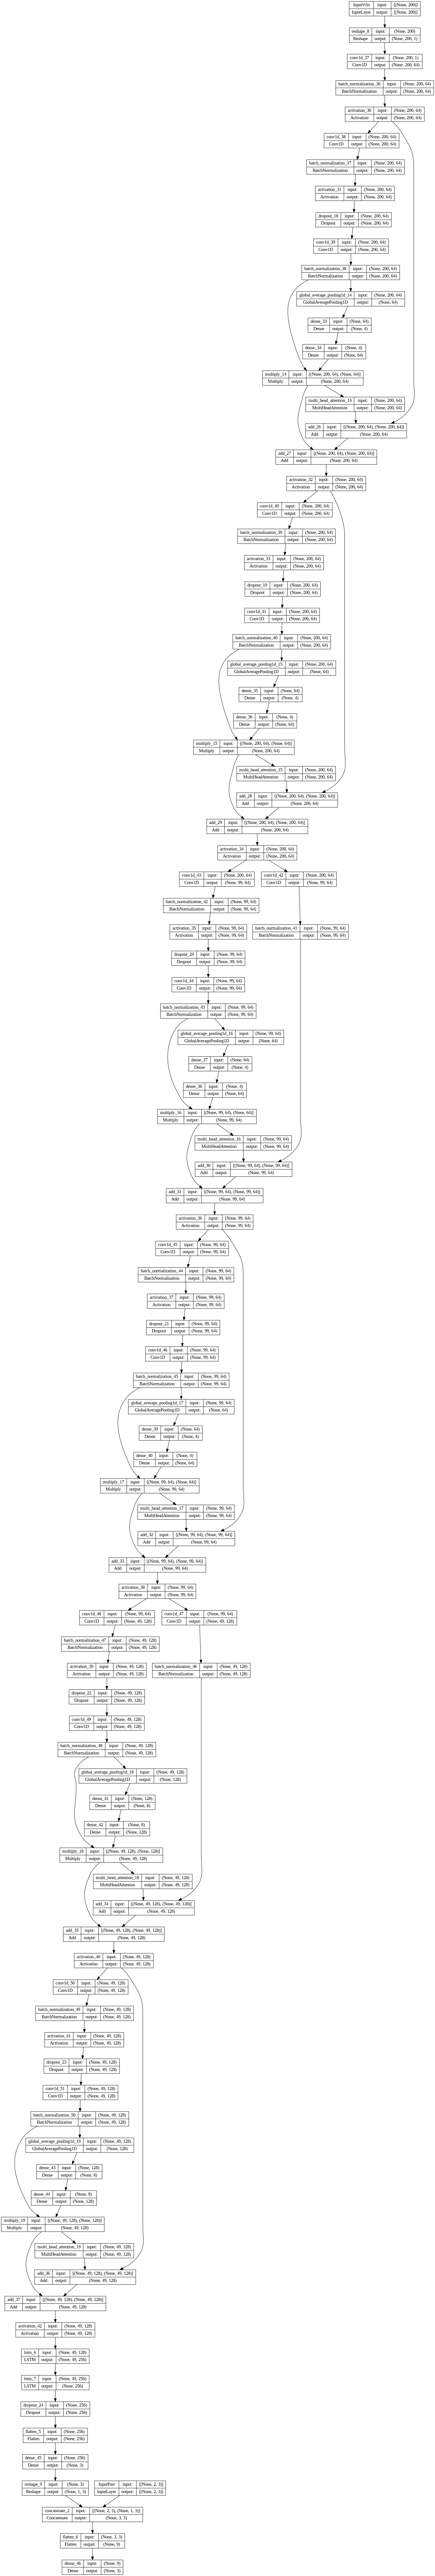

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

# Squeeze and excitation module
def se_block(in_block, channel, ratio=16):
    # Squeeze into single element per input filters
    squeeze = tfkl.GlobalAveragePooling1D()(in_block)

    # Compress these single elements into a lower nº of units (given by the ratio indicated)
    excitation = tfkl.Dense(channel // ratio, activation='relu')(squeeze)

    # Expand again the compressed elements into the input dimension: obtaining of a weight for each channel
    excitation = tfkl.Dense(channel, activation='sigmoid')(excitation)

    # Multiplication of each input filter with their corresponding weights
    scaled_input = tfkl.multiply([in_block, excitation])
    return scaled_input

# ResNet with Squeeze and excitation block model definition
def ResBs_SE_Conv_with_attention(block_input, num_filters=64, kernel_size=3):
    # Filter Block input and BatchNormalization
    block_input_short = tfkl.Conv1D(num_filters, kernel_size=kernel_size, strides=2, padding='valid')(block_input)
    block_input_short = tfkl.BatchNormalization()(block_input_short)

    # First Convolutional Layer
    conv1 = tfkl.Conv1D(filters=num_filters, kernel_size=kernel_size, strides=2, padding='valid')(block_input)
    norm1 = tfkl.BatchNormalization()(conv1)
    relu1 = tfkl.Activation('relu')(norm1)
    dropout = tfkl.Dropout(0.5)(relu1)

    # Second Convolutional Layer
    conv2 = tfkl.Conv1D(num_filters, kernel_size=kernel_size, padding='same')(dropout)
    norm2 = tfkl.BatchNormalization()(conv2)

    # SE block --> Channel attention layer
    se = se_block(norm2, channel=num_filters)

    # Self-Attention layer
    attention = tfkl.MultiHeadAttention(num_heads=1, key_dim=num_filters)(se, se, se)

    # Element-wise addition of the attention output and the original block_input
    block_input_short = tfkl.Add()([block_input_short, attention])

    # Summing Layer (adding a residual connection)
    sum = tfkl.Add()([block_input_short, se])

    # Activation Layer
    relu2 = tfkl.Activation('relu')(sum)

    return relu2

def ResBs_SE_Identity_with_attention(block_input, num_filters=64, kernel_size=3):
    # First Convolutional Layer
    conv1 = tfkl.Conv1D(filters=num_filters, kernel_size=kernel_size, padding='same')(block_input)
    norm1 = tfkl.BatchNormalization()(conv1)
    relu1 = tfkl.Activation('relu')(norm1)
    dropout = tfkl.Dropout(0.5)(relu1)

    # Second Convolutional Layer
    conv2 = tfkl.Conv1D(num_filters, kernel_size=kernel_size, padding='same')(dropout)
    norm2 = tfkl.BatchNormalization()(conv2)

    # SE block (function defined above)
    se = se_block(norm2, channel=num_filters)

    # Self-Attention layer
    attention = tfkl.MultiHeadAttention(num_heads=1, key_dim=num_filters)(se, se, se)

    # Element-wise addition of the attention output and the original block_input
    block_input = tfkl.Add()([block_input, attention])

    # Summing Layer (adding a residual connection)
    sum = tfkl.Add()([block_input, se])

    # Activation Layer
    relu2 = tfkl.Activation('relu')(sum)

    return relu2

def build_freq_model(inputwin_shape, inputpast_shape, classes, kernel_size, num_resnet_blocks, num_filters):


    inputwin_layer = tfkl.Input(shape=inputwin_shape, name='InputWin')
    inputpast_layer = tfkl.Input(shape=inputpast_shape, name='InputPast')

    # Build the model
    x = tfkl.Reshape((inputwin_shape[0], 1))(inputwin_layer)
    ResNet = tfkl.Conv1D(filters=64, kernel_size=kernel_size, padding='same')(x)
    ResNet = tfkl.BatchNormalization()(ResNet)
    ResNet = tfkl.Activation('relu')(ResNet)

    # B.5 ResBs blocks
    # First two ResNet blocks are identity blocks
    ResNet = ResBs_SE_Identity_with_attention(ResNet, num_filters=num_filters, kernel_size=kernel_size)
    ResNet = ResBs_SE_Identity_with_attention(ResNet, num_filters=num_filters, kernel_size=kernel_size)

    num_remaining_resnet_blocks = int((num_resnet_blocks - 2) / 2)
    for _ in range(num_remaining_resnet_blocks):
        # define N-th ResBs block
        ResNet = ResBs_SE_Conv_with_attention(ResNet, num_filters=num_filters, kernel_size=kernel_size)
        ResNet = ResBs_SE_Identity_with_attention(ResNet, num_filters=num_filters, kernel_size=kernel_size)
        num_filters *= 2

    # Apply LSTMs to better capture long-term dependencies and temporal relations in the sequential data
    ResNet = tfkl.LSTM(units=256, return_sequences=True)(ResNet)
    ResNet = tfkl.LSTM(units=256)(ResNet)
    ResNet = tfkl.Dropout(0.5)(ResNet)

     # Flatten and dense layers
    x = tfkl.Flatten()(ResNet)
    x = tfkl.Dense(classes, activation='relu')(x)

    # Concatenate with inputpast_layer
    x2 = tfkl.Reshape((1, 3))(x)
    xc = tfkl.Concatenate(axis=1)([inputpast_layer, x2])
    x = tfkl.Flatten()(xc)

    # Output layer with softmax activation
    output_layer = tfkl.Dense(classes, activation='softmax')(x)

    # Compile the model
    model = tf.keras.Model(inputs=[inputwin_layer, inputpast_layer], outputs=output_layer)
    return model


# Assuming XtrainW[0] and XtrainP[0] are your training data
freqmodel = build_freq_model(inputwin_shape=fXtrainW[0].shape, inputpast_shape=fXtrainP[0].shape, classes=3, kernel_size=3, num_resnet_blocks=6, num_filters=64)
freqmodel.summary()
tf.keras.utils.plot_model(freqmodel, show_shapes=True)

In [ ]:
BATCH_SIZE = 128
EPOCHS = 1000
LEARNING_RATE = 1e-3

freqmodel.compile(
    loss=tfk.losses.CategoricalCrossentropy(),
    optimizer=tfk.optimizers.Adam(learning_rate=LEARNING_RATE),
    metrics= 'accuracy'
)

# Define your learning rate schedule function
def lr_schedule(epoch, lr):
    if epoch < 10:
        return lr  # Use the initial learning rate for the first 10 epochs
    else:
        return lr * tf.math.exp(-0.1)  # Decay the learning rate exponentially

# Create a LearningRateScheduler callback
lr_scheduler = tfk.callbacks.LearningRateScheduler(lr_schedule)

# Add the LR callback to the list of callbacks
callbacks_list = [
    tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=5),
    lr_scheduler
]

history = freqmodel.fit(
    x=[fXtrainW, fXtrainP],
    y=Ytrain,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=([fXvalW, fXvalP], fYval),
    callbacks=callbacks_list
).history

Epoch 1/1000


130/130 [==============================] - ETA: 0s - loss: 0.6476 - accuracy: 0.6779

130/130 [==============================] - 37s 99ms/step - loss: 0.6476 - accuracy: 0.6779 - val_loss: 0.5313 - val_accuracy: 0.7449 - lr: 0.0010
Epoch 2/1000
130/130 [==============================] - 10s 77ms/step - loss: 0.4732 - accuracy: 0.7681 - val_loss: 0.4206 - val_accuracy: 0.8076 - lr: 0.0010
Epoch 3/1000
130/130 [==============================] - 10s 79ms/step - loss: 0.4260 - accuracy: 0.7940 - val_loss: 0.4304 - val_accuracy: 0.8117 - lr: 0.0010
Epoch 4/1000
130/130 [==============================] - 10s 76ms/step - loss: 0.4100 - accuracy: 0.8023 - val_loss: 0.4068 - val_accuracy: 0.8203 - lr: 0.0010
Epoch 5/1000
130/130 [==============================] - 10s 78ms/step - loss: 0.3955 - accuracy: 0.8111 - val_loss: 0.3776 - val_accuracy: 0.8268 - lr: 0.0010
Epoch 6/1000
130/130 [==============================] - 11s 81ms/step - loss: 0.3858 - accuracy: 0.8188 - val_loss: 0.3812 - val_accuracy: 0.8280 - lr: 0.0010
Epoch 7/1000
130/130 [==============================] - 11s

TRAINING HISTORY


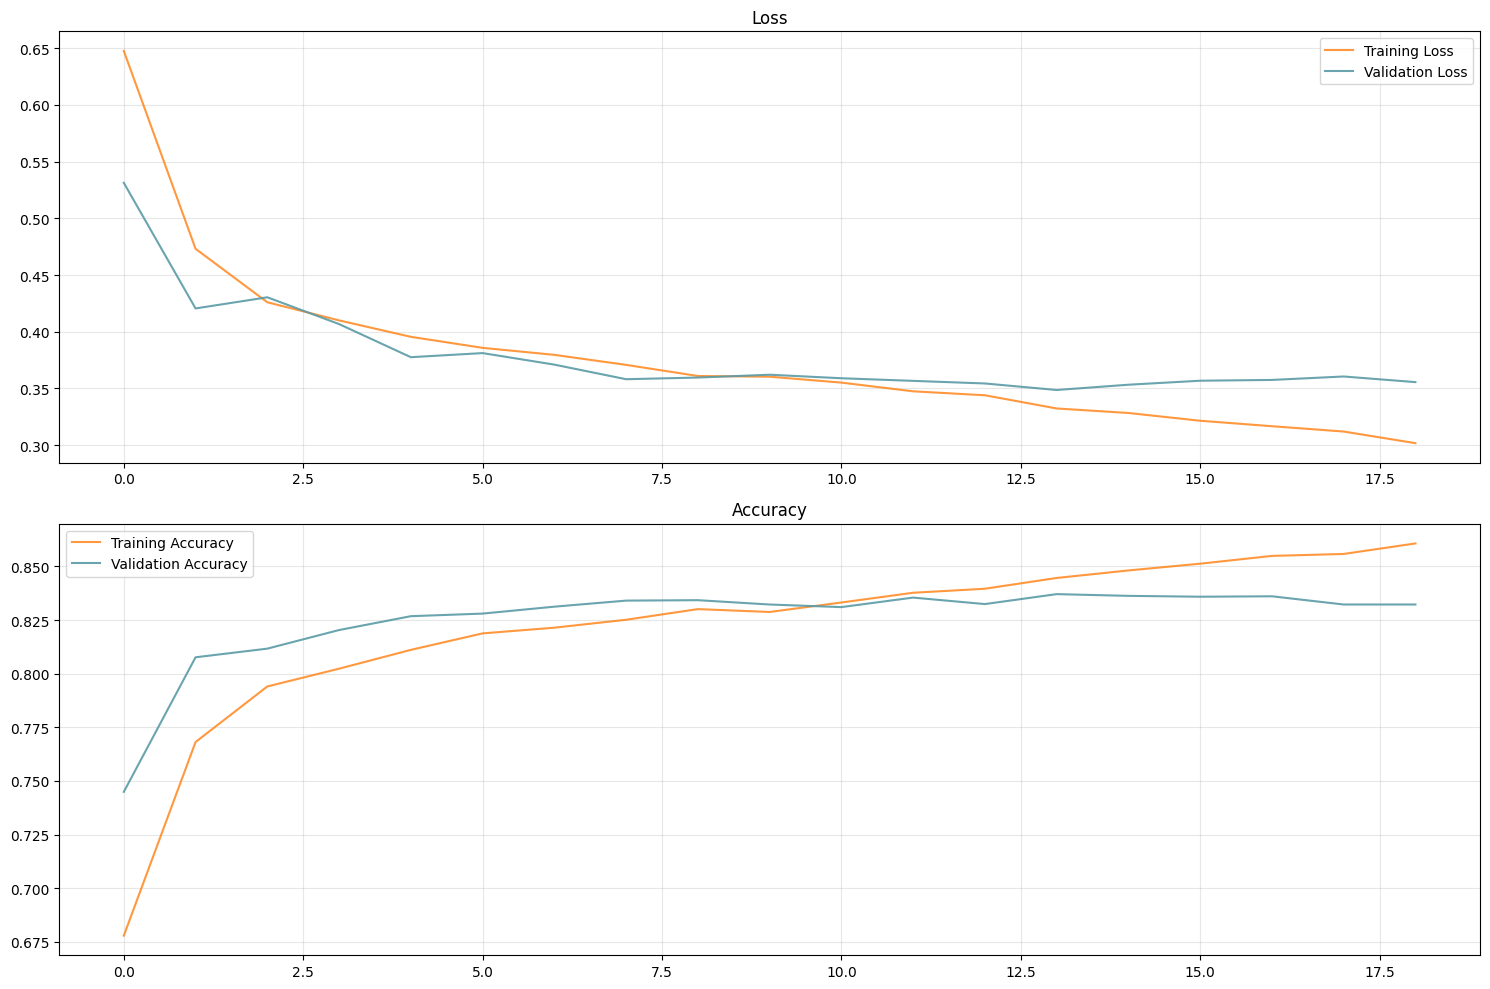

In [ ]:
print("TRAINING HISTORY")
plt.figure(figsize=(15, 10))

# Plot Training and Validation Loss
plt.subplot(2, 1, 1)
plt.plot(history['loss'], label='Training Loss', alpha=0.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation Loss', alpha=0.9, color='#5a9aa5')
plt.title('Loss')
plt.legend()
plt.grid(alpha=0.3)

# Plot Training and Validation Accuracy
plt.subplot(2, 1, 2)
plt.plot(history['accuracy'], label='Training Accuracy', alpha=0.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation Accuracy', alpha=0.9, color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
preds = np.argmax(freqmodel.predict([fXtestW, fXtestP]), axis=1)
Ytestt = np.argmax(Ytest, axis=1)
corrects = preds == Ytestt
print("ACCURACY: ", np.count_nonzero(corrects) / corrects.shape[0])

67/67 [==============================] - 2s 10ms/step
ACCURACY:  0.8273753527751646


CONFUSION MATRIX
[[894 168]
 [199 865]]


              precision    recall  f1-score   support

           0       0.82      0.84      0.83      1062
           1       0.84      0.81      0.82      1064

    accuracy                           0.83      2126
   macro avg       0.83      0.83      0.83      2126
weighted avg       0.83      0.83      0.83      2126



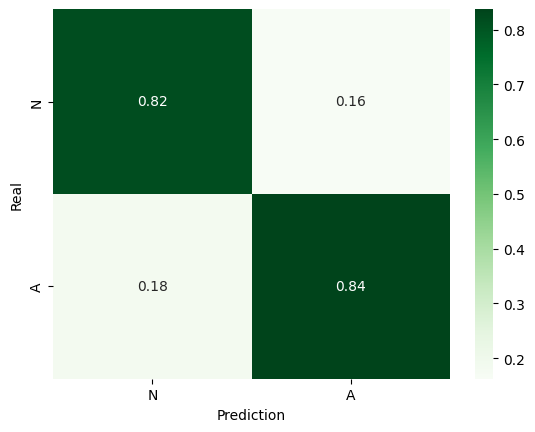

In [ ]:
print("CONFUSION MATRIX")
print(sklearn.metrics.confusion_matrix(Ytestt, preds))
print()
print()
print(sklearn.metrics.classification_report(Ytestt, preds))

cmt = sklearn.metrics.confusion_matrix(Ytestt, preds) / np.sum(sklearn.metrics.confusion_matrix(Ytestt, preds), axis=0)
hm = sns.heatmap(cmt, annot=True, fmt=".2f", cmap="Greens")
hm.set_xticklabels(['N', 'A'])
hm.set_xlabel("Prediction")
hm.set_ylabel("Real")
hm.set_yticklabels(['N', 'A'])
plt.show()

In [ ]:
import os
from datetime import datetime
from tensorflow.keras.models import save_model

# Save the model
time_stamp = datetime.now().strftime("%Y%m%d_%H%M")
freqmodel_folder = '/gdrive/MyDrive/AI_project/models/freq_models'
freqmodel_name = f"freq_model_{time_stamp}_newPreprocessing_undersampling_RESSELFCHANNEL"  # Add additional info if needed

# Assuming timemodel is your model
save_model(freqmodel, os.path.join(freqmodel_folder, f"{freqmodel_name}.h5"))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-47-dce9fd0c90f4>:11: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(freqmodel, os.path.join(freqmodel_folder, f"{freqmodel_name}.h5"))


#### Reload the models (only used if other models should be evaluated, otherwise skip this line)

In [ ]:
#Load TIME Model
time_model_file_path = '/gdrive/MyDrive/AI_project/models/time_models/time_model_20231226_0004_newPreprocessing_undersampling.h5'
timemodel = tfk.models.load_model(time_model_file_path)

timemodel.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 InputWin (InputLayer)       [(None, 200)]                0         []                            
                                                                                                  
 reshape_4 (Reshape)         (None, 200, 1)               0         ['InputWin[0][0]']            
                                                                                                  
 lstm_4 (LSTM)               (None, 200, 128)             66560     ['reshape_4[0][0]']           
                                                                                                  
 conv1d_4 (Conv1D)           (None, 200, 64)              24640     ['lstm_4[0][0]']              
                                                                                            

In [ ]:
#Load FREQ Model
freq_model_file_path = '/gdrive/MyDrive/AI_project/models/freq_models/freq_model_20231221_1820_firstTry.h5'
freq_model = tfk.models.load_model(freq_model_file_path)

freq_model.summary()

Model: "PAC_PVC_classifier"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 InputWin (InputLayer)       [(None, 150)]                0         []                            
                                                                                                  
 reshape_18 (Reshape)        (None, 150, 1)               0         ['InputWin[0][0]']            
                                                                                                  
 conv1d_12 (Conv1D)          (None, 148, 16)              64        ['reshape_18[0][0]']          
                                                                                                  
 activation_6 (Activation)   (None, 148, 16)              0         ['conv1d_12[0][0]']           
                                                                                 

#### Ensemble 1: Argmax

In [ ]:
def ensemble_predict(model1_preds, model2_preds):
    # Combine predictions by summing
    combined_preds = model1_preds + model2_preds

    # Take argmax to get final predictions
    final_preds = np.argmax(combined_preds, axis=1)

    return final_preds

# Assuming you have time_model and freq_model already trained and XtestW_scaled, XtestP prepared
#time_preds = time_model.predict([XtestW_scaled, XtestP])
#freq_preds = freq_model.predict([np.fft.fft(XtestW, axis=1), XtestP])

time_preds = timemodel.predict([XtestW, XtestP])
freq_preds = freqmodel.predict([fXtestW, fXtestP])

# Use the ensemble function
ensemble_preds = ensemble_predict(time_preds, freq_preds)

# Evaluate the ensemble predictions
Ytestt = np.argmax(Ytest, axis=1)
corrects = ensemble_preds == Ytestt

print("Accuracy: ", np.count_nonzero(corrects) / corrects.shape[0])
print(sklearn.metrics.confusion_matrix(Ytestt, ensemble_preds))
print()
print(sklearn.metrics.classification_report(Ytestt, ensemble_preds))

67/67 [==============================] - 1s 11ms/step
Accuracy:  0.8598306679209784
[[916 146]
 [152 912]]

              precision    recall  f1-score   support

           0       0.86      0.86      0.86      1062
           1       0.86      0.86      0.86      1064

    accuracy                           0.86      2126
   macro avg       0.86      0.86      0.86      2126
weighted avg       0.86      0.86      0.86      2126



#### Ensemble 2: Averaging

In [ ]:
def average_ensemble_predict(model1_preds, model2_preds):
    # Average predictions
    averaged_preds = (model1_preds + model2_preds) / 2.0

    # Take argmax to get final predictions
    final_preds = np.argmax(averaged_preds, axis=1)

    return final_preds

# Assuming you have time_model and freq_model already trained and XtestW_scaled, XtestP prepared
time_preds = timemodel.predict([XtestW, XtestP])
freq_preds = freqmodel.predict([np.fft.fft(XtestW, axis=1), XtestP])

# Use the averaging ensemble function
ensemble_preds = average_ensemble_predict(time_preds, freq_preds)

# Evaluate the ensemble predictions
Ytestt = np.argmax(Ytest, axis=1)
corrects = ensemble_preds == Ytestt

print("Accuracy: ", np.count_nonzero(corrects) / corrects.shape[0])
print(sklearn.metrics.confusion_matrix(Ytestt, ensemble_preds))
print()
print(sklearn.metrics.classification_report(Ytestt, ensemble_preds))

67/67 [==============================] - 1s 8ms/step
Accuracy:  0.8598306679209784
[[916 146]
 [152 912]]

              precision    recall  f1-score   support

           0       0.86      0.86      0.86      1062
           1       0.86      0.86      0.86      1064

    accuracy                           0.86      2126
   macro avg       0.86      0.86      0.86      2126
weighted avg       0.86      0.86      0.86      2126



### **3.2** Detect between normal, ventricular and superventricular beats

#### Label and data set creation

In [ ]:
N,S,V = 0,0,0
X=0
l=0
for p in patient:
    l+=p.peaklabels.shape[0]
    N+=np.count_nonzero(p.peaklabels=='N')
    S+=np.count_nonzero(p.peaklabels=='S')
    V+=np.count_nonzero(p.peaklabels=='V')
print("NUMBER OF BEATS: Normal: ",N,"- Sopraventricular: ",S,"- Ventricular:",V)
print("PERCENTAGE: Normal: ",N/(N+S+V),"- Sopraventricular: ",S/(N+S+V),"- Ventricular:",V/(N+S+V),)

NUMBER OF BEATS: Normal:  129807 - Sopraventricular:  6736 - Ventricular: 5080
PERCENTAGE: Normal:  0.9165672242502984 - Sopraventricular:  0.04756289585731131 - Ventricular: 0.03586987989239036


In [ ]:
categorical = {'N':np.array([1,0,0,0]),'S':np.array([0,1,0,0]),'V':np.array([0,0,1,0]), 'p':np.array([0,0,0,1])}

In [ ]:
import numpy as np


min_examples_per_category = round(min([N, S, V]))

def build_dataset(patients, width=200):
    X_Win = []
    X_Past = []
    Y = []
    patient_ID = []
    category_counts = {tuple(category): 0 for category in categorical.values()}

    for p in patients:
        split = p.split_peaks(borders=0.05, fixed_length=width)
        vect = np.arange(0, len(split))
        np.random.shuffle(vect)

        for i in vect:
            category = tuple(categorical[p.peaklabels[i]])

            if category_counts[category] < min_examples_per_category:
                X_Win.append(np.array(split[i]))
                Y.append(category)

                if i >= 2:
                    X_Past.append(np.array([categorical[p.peaklabels[i-2]], categorical[p.peaklabels[i-1]]]))
                elif i == 1:
                    X_Past.append(np.array([categorical['p'], categorical[p.peaklabels[i-1]]]))
                else:
                    X_Past.append(np.array([categorical['p'], categorical['p']]))

                category_counts[category] += 1

    return (np.stack(X_Win, axis=0), np.stack(X_Past, axis=0)), np.stack(Y, axis=0)

(X_W, X_P), Y = build_dataset(patient, 200)

print(f"INPUT WINDOW shape: {X_W.shape} as (WINDOW, TIME)")
print(f"INPUT PAST shape: {X_P.shape} as (WINDOW, PAST, one-hot-LABEL)")
print(f"OUTPUT shape: {Y.shape} as (WINDOW, one-hot-LABEL)")



INPUT WINDOW shape: (15240, 200) as (WINDOW, TIME)
INPUT PAST shape: (15240, 2, 4) as (WINDOW, PAST, one-hot-LABEL)
OUTPUT shape: (15240, 4) as (WINDOW, one-hot-LABEL)


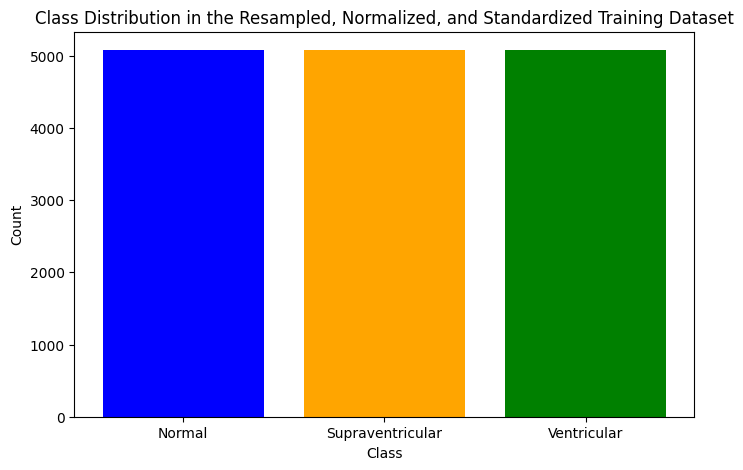

In [ ]:
from sklearn.model_selection import train_test_split

# Split into training and validation sets
XtrainW, XvalW, XtrainP, XvalP, Ytrain, Yval = train_test_split(
    X_W, X_P, Y,
    test_size=0.3, shuffle=True, stratify=Y, random_state = SEED
)

# Split into validation and test sets
XvalW, XtestW, XvalP, XtestP, Yval, Ytest = train_test_split(
    XvalW, XvalP, Yval,
    test_size=0.3, shuffle=True, stratify=Yval, random_state = SEED
)


# Plot barplots for the resampled and standardized dataset
plt.figure(figsize=(8, 5))
plt.bar(['Normal', 'Supraventricular', 'Ventricular'], np.bincount(np.argmax(Y, axis=1)), color=['blue', 'orange', 'green'])
plt.title('Class Distribution in the Resampled, Normalized, and Standardized Training Dataset')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


In [ ]:
XtrainW.shape

(10668, 200)

In [ ]:
XvalW.shape

(3200, 200)

In [ ]:
XtestW.shape

(1372, 200)

#### Standardisation

In [ ]:
# Concatenate all windows in XtrainW
XtrainW_all = np.concatenate(XtrainW, axis=0)
XtrainW_all.shape

# Calculate mean and standard deviation for each feature
signal_mean, signal_std = np.mean(XtrainW_all, axis=0), np.std(XtrainW_all, axis=0)
print(f"Signal: mean = {signal_mean} std = {signal_std}")

Signal: mean = 0.5106481690861394 std = 0.06435720986064188


In [ ]:
XtrainW[:,:] = (XtrainW[:,:]-signal_mean)/signal_std

XvalW[:,:] = (XvalW[:,:]-signal_mean)/signal_std

XtestW[:,:] = (XtestW[:,:]-signal_mean)/signal_std


Xtrain_res = np.concatenate(XtrainW)
train_mean,train_std = np.mean(Xtrain_res[:]),np.std(Xtrain_res[:])

print(f"Training: mean = {train_mean} std = {train_std}")


Xtest_res = np.concatenate(XtestW)
test_mean,test_std = np.mean(Xtest_res[:]),np.std(Xtest_res[:])

print(f"Test: mean = {test_mean} std = {test_std}")


Xval_res = np.concatenate(XvalW)
val_mean,val_std = np.mean(Xval_res[:]),np.std(Xval_res[:])

print(f"Validation: mean = {val_mean} std = {val_std}")


Training: mean = 1.0270499611380526e-17 std = 0.9999999999999991
Test: mean = 0.009548154901281827 std = 0.9168630237434222
Validation: mean = 0.002441190607558885 std = 0.9468047799509886


#### Time domain model

##### Time Model Architecture Overview

We designed this model to process time-series data with two distinct input streams: `InputWin` and `InputPast`. The model utilizes LSTM layers followed by convolutional layers and dense layers for classification.

##### Inputs

- `InputWin`: Input for the current window of time-series data.
- `InputPast`: Input for the past data.

##### Layers

1. **Input Layer**:
    - `InputWin`: Shape defined by `inputwin_shape`.
    - `InputPast`: Shape defined by `inputpast_shape`.

2. **Preprocessing**:
    - `Reshape`: Reshapes the `InputWin` to add a time_steps dimension.

3. **LSTM and Convolutional Layers**:
    - `LSTM`: Recurrent layer with 256 units.
    - `Conv1D`: Convolutional layers with 128 filters and kernel size of 5.
    - `BatchNormalization`: Normalizes the activations.
    - `Activation`: ReLU activation function.
    - `MaxPooling1D`: Max pooling layer with pool size of 2.
    - `Dropout`: Dropout regularization with a rate of 0.4 or 0.5.

4. **Flatten and Dense Layers**:
    - `Flatten`: Flattens the input.
    - `Dense`: Fully connected layers with 512 and 4 units respectively, using ReLU activation.

5. **Concatenation and Output Layer**:
    - `Concatenate`: Concatenates the flattened output with `InputPast`.
    - `Dense`: Output layer with a softmax activation function for classification into `classes` categories.

##### Model Parameters

- `classes`: Number of output classes.
- `Dropout rates`: 0.4 and 0.5 for regularization.


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 InputWin (InputLayer)       [(None, 200)]                0         []                            
                                                                                                  
 reshape_37 (Reshape)        (None, 200, 1)               0         ['InputWin[0][0]']            
                                                                                                  
 lstm_36 (LSTM)              (None, 200, 256)             264192    ['reshape_37[0][0]']          
                                                                                                  
 conv1d_62 (Conv1D)          (None, 200, 128)             163968    ['lstm_36[0][0]']             
                                                                                            

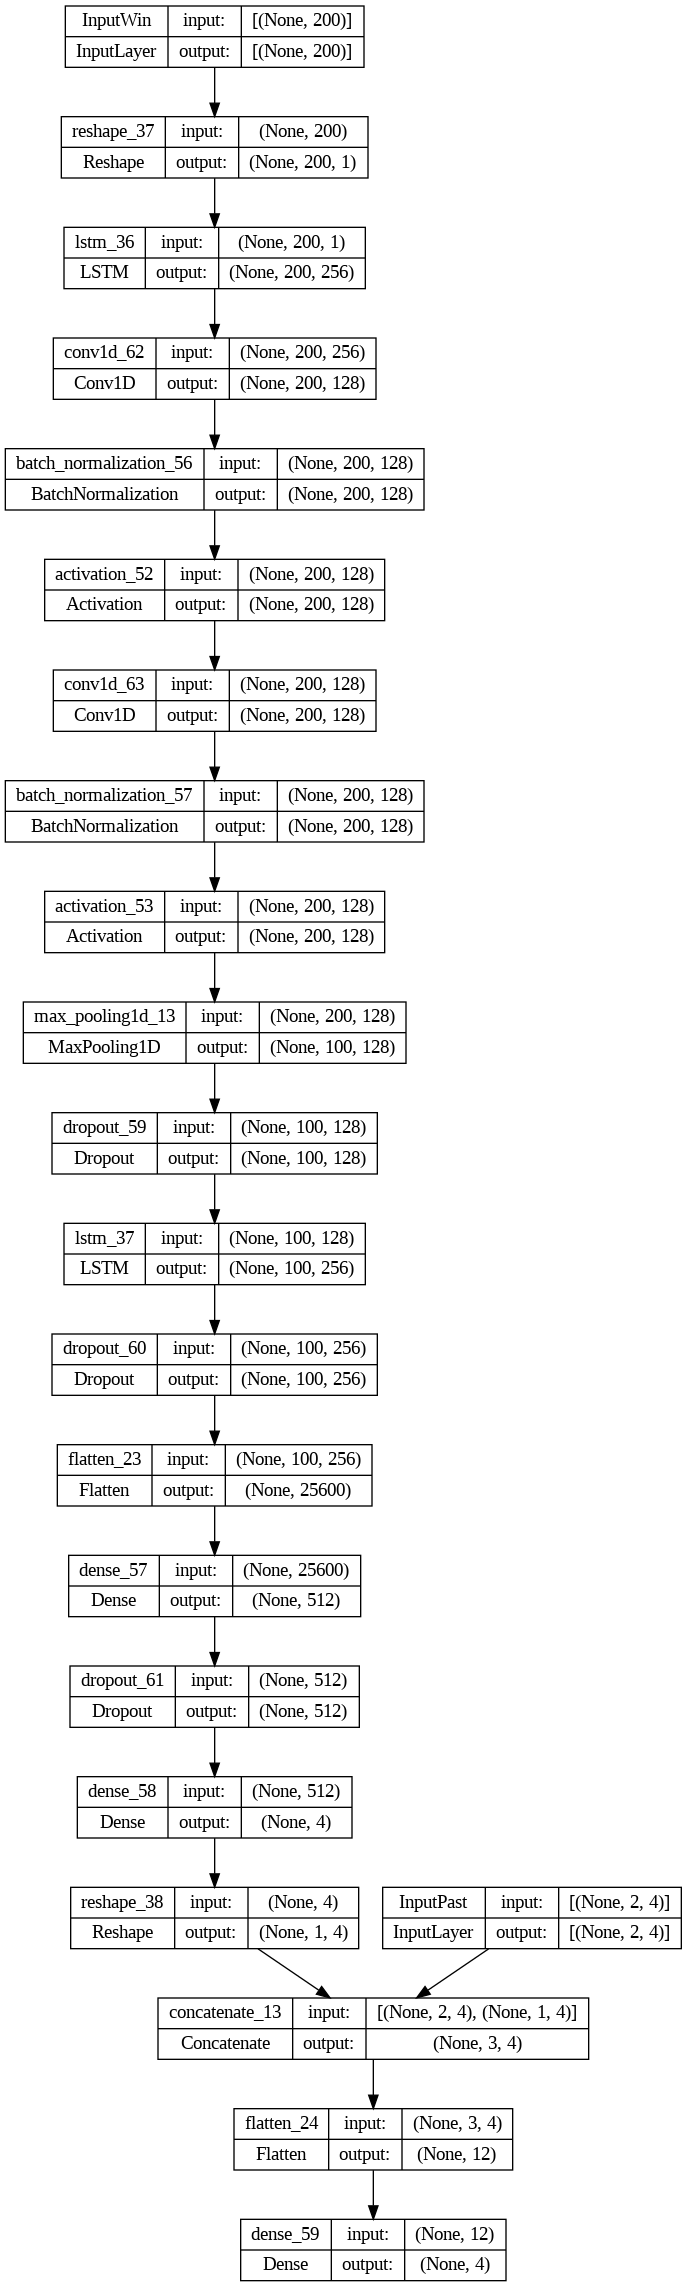

In [ ]:
import tensorflow.keras.layers as tfkl
import tensorflow as tf

def build_time_model(inputwin_shape, inputpast_shape, classes):
    inputwin_layer = tfkl.Input(shape=inputwin_shape, name='InputWin')
    inputpast_layer = tfkl.Input(shape=inputpast_shape, name='InputPast')

    # Reshape inputwin_layer to add the time_steps dimension
    x = tfkl.Reshape((inputwin_shape[0], 1))(inputwin_layer)

    # Initial convolutional layer
    x = tfkl.LSTM(256, return_sequences=True)(x)
    x = tfkl.Conv1D(filters=128, kernel_size=5, padding='same')(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Activation('relu')(x)
    x = tfkl.Conv1D(filters=128, kernel_size=5, padding='same')(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Activation('relu')(x)
    x = tfkl.MaxPooling1D(pool_size=2)(x)
    x = tfkl.Dropout(0.4)(x)

    x = tfkl.LSTM(256, return_sequences=True)(x)
    x = tfkl.Dropout(0.4)(x)

    # Flatten and dense layers
    x = tfkl.Flatten()(x)
    x = tfkl.Dense(512, activation='relu')(x)
    x = tfkl.Dropout(0.5)(x)
    x = tfkl.Dense(4, activation='relu')(x)

    # Concatenate with inputpast_layer
    x2 = tfkl.Reshape((1, 4))(x)
    xc = tfkl.Concatenate(axis=1)([inputpast_layer, x2])
    x = tfkl.Flatten()(xc)

    # Output layer with softmax activation
    output_layer = tfkl.Dense(classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=[inputwin_layer, inputpast_layer], outputs=output_layer)
    return model

# Assuming XtrainW[0] and XtrainP[0] are your training data
timemodel = build_time_model(inputwin_shape=XtrainW[0].shape, inputpast_shape=XtrainP[0].shape, classes=4)
timemodel.summary()
tf.keras.utils.plot_model(timemodel, show_shapes=True)


##### Class Weighting, Training and prediction

In [ ]:
print("CLASS WEIGHTING")
N_count = np.count_nonzero(np.argmax(Ytrain, axis=1) == 0)
S_count = np.count_nonzero(np.argmax(Ytrain, axis=1) == 1)
V_count = np.count_nonzero(np.argmax(Ytrain, axis=1) == 2)

N_samples = N_count + V_count + S_count

# Assign higher weights to classes 1 and 2
CLASS_WEIGHT = {
    0: N_samples / (3 * N_count),
    1: N_samples / (3 * S_count),  # Increase weight for class 1
    2: N_samples / (3 * V_count),  # Increase weight for class 2
    3: 0,

}
print(CLASS_WEIGHT)


CLASS WEIGHTING
{0: 1.0, 1: 1.0, 2: 1.0, 3: 0}


In [ ]:
BATCH_SIZE = 128
EPOCHS = 1000
LEARNING_RATE = 1e-3

timemodel.compile(
    loss=tfk.losses.CategoricalCrossentropy(),
    optimizer=tfk.optimizers.Adam(learning_rate=LEARNING_RATE),
    metrics= 'accuracy'
)

# Define your learning rate schedule function
def lr_schedule(epoch, lr):
    if epoch < 10:
        return lr  # Use the initial learning rate for the first 10 epochs
    else:
        return lr * tf.math.exp(-0.1)  # Decay the learning rate exponentially

# Create a LearningRateScheduler callback
lr_scheduler = tfk.callbacks.LearningRateScheduler(lr_schedule)

# Add the LR callback to the list of callbacks
callbacks_list = [
    tfk.callbacks.EarlyStopping(monitor='accuracy', mode='max', patience=5),
    lr_scheduler
]

history = timemodel.fit(
    x=[XtrainW, XtrainP],
    y=Ytrain,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    class_weight=CLASS_WEIGHT,
    validation_data=([XvalW, XvalP], Yval),
    callbacks=callbacks_list
).history


Epoch 1/1000
84/84 [==============================] - 12s 81ms/step - loss: 1.2507 - accuracy: 0.4007 - val_loss: 1.1204 - val_accuracy: 0.4569 - lr: 0.0010
Epoch 2/1000
84/84 [==============================] - 6s 68ms/step - loss: 1.0993 - accuracy: 0.5111 - val_loss: 1.3090 - val_accuracy: 0.4406 - lr: 0.0010
Epoch 3/1000
84/84 [==============================] - 6s 68ms/step - loss: 1.0066 - accuracy: 0.5405 - val_loss: 0.9045 - val_accuracy: 0.5809 - lr: 0.0010
Epoch 4/1000
84/84 [==============================] - 6s 68ms/step - loss: 0.8719 - accuracy: 0.5957 - val_loss: 0.7566 - val_accuracy: 0.5803 - lr: 0.0010
Epoch 5/1000
84/84 [==============================] - 6s 68ms/step - loss: 0.6894 - accuracy: 0.7087 - val_loss: 0.7290 - val_accuracy: 0.6503 - lr: 0.0010
Epoch 6/1000
84/84 [==============================] - 6s 69ms/step - loss: 0.5513 - accuracy: 0.7753 - val_loss: 0.7850 - val_accuracy: 0.6719 - lr: 0.0010
Epoch 7/1000
84/84 [==============================] - 6s 68ms/s

TRAINING HISTORY


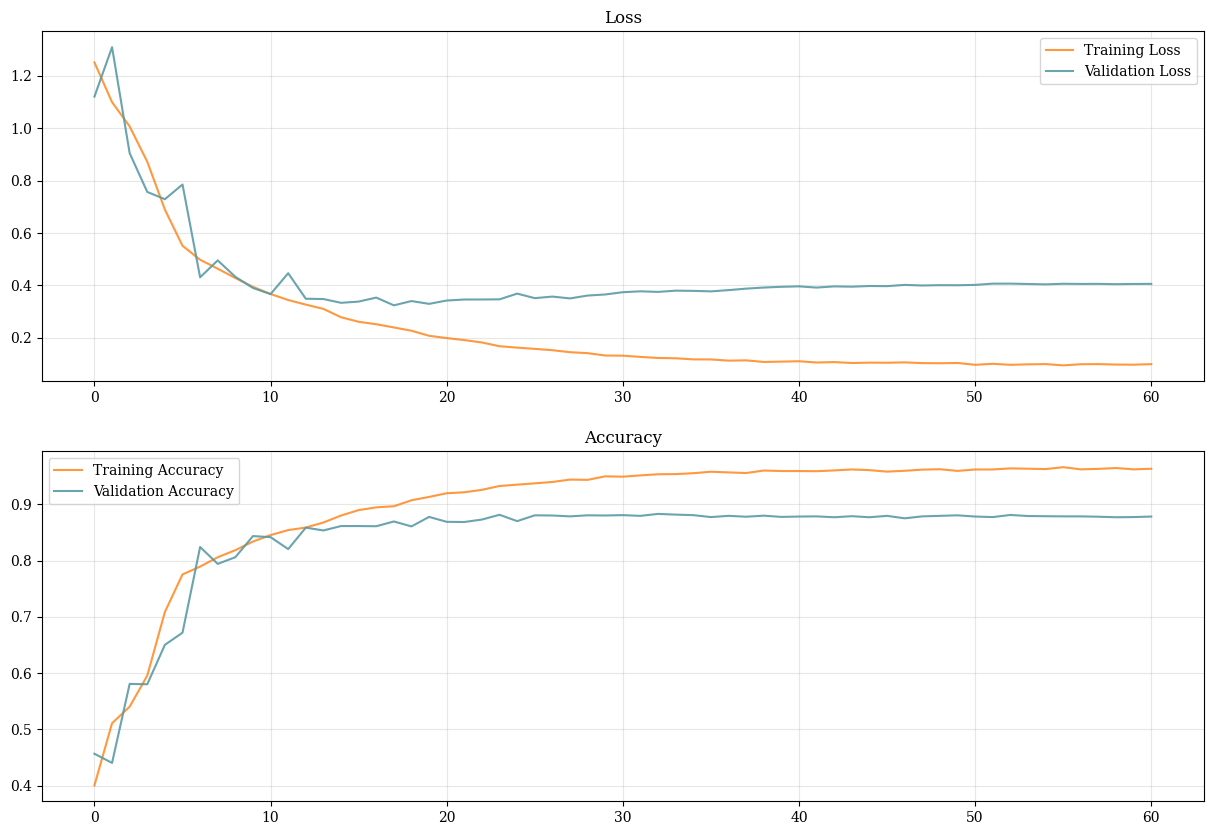

In [ ]:
print("TRAINING HISTORY")
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
plt.plot(history['loss'], label='Training Loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation Loss', alpha=.9, color='#5a9aa5')
plt.title('Loss')
plt.legend()
plt.grid(alpha=.3)
plt.subplot(2, 1, 2)
plt.plot(history['accuracy'], label='Training Accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation Accuracy', alpha=.9, color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
preds = np.argmax(timemodel.predict([XtestW, XtestP]), axis=1)
Ytestt = np.argmax(Ytest, axis=1)
corrects = preds == Ytestt
print("ACCURACY:", np.count_nonzero(corrects) / corrects.shape[0])

43/43 [==============================] - 1s 12ms/step
ACCURACY: 0.8731778425655977


CONFUSION MATRIX
[[408  12  38]
 [  6 396  55]
 [ 12  51 394]]


              precision    recall  f1-score   support

           0       0.96      0.89      0.92       458
           1       0.86      0.87      0.86       457
           2       0.81      0.86      0.83       457

    accuracy                           0.87      1372
   macro avg       0.88      0.87      0.87      1372
weighted avg       0.88      0.87      0.87      1372



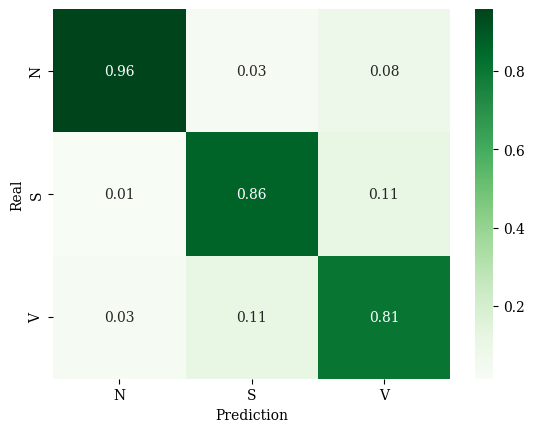

In [ ]:
print("CONFUSION MATRIX")
print(sklearn.metrics.confusion_matrix(Ytestt,preds))
print()
print()
print(sklearn.metrics.classification_report(Ytestt,preds))

cmt = sklearn.metrics.confusion_matrix(Ytestt,preds)/np.sum(sklearn.metrics.confusion_matrix(Ytestt,preds),axis=0)
hm=sns.heatmap(cmt,annot=True,fmt=".2f",cmap="Greens")
hm.set_xticklabels(['N','S','V'])
hm.set_xlabel("Prediction")
hm.set_ylabel("Real")
hm.set_yticklabels(['N','S','V'])
plt.show()

In [ ]:
import os
from datetime import datetime
from tensorflow.keras.models import save_model

# Save the model
time_stamp = datetime.now().strftime("%Y%m%d_%H%M")
timemodel_folder = '/gdrive/MyDrive/AI_project/models/time_models'
timemodel_name = f"time_model_{time_stamp}_newPreprocessing_undersampling_BALANCED_FINAL_TASK2_seed"  # Add additional info if needed

# Assuming timemodel is your model
save_model(timemodel, os.path.join(timemodel_folder, f"{timemodel_name}.h5"))

<ipython-input-96-072842bc28bf>:11: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(timemodel, os.path.join(timemodel_folder, f"{timemodel_name}.h5"))


#### Frequency Domain Model

In [ ]:
fXtrainW = np.fft.fft(XtrainW, axis=1)
fXvalW = np.fft.fft(XvalW, axis=1)
fXtestW = np.fft.fft(XtestW, axis=1)
fYtrain = Ytrain
fYval = Yval
fYtest = Ytest
fXtrainP = XtrainP
fXvalP = XvalP
fXtestP = XtestP

##### Frequency Model Architecture Overview

We designed this model for processing time-series data using a ResNet-like structure augmented with Squeeze and Excitation (SE) blocks and self-attention mechanisms. The model aims to capture both spatial and temporal dependencies in the data.

##### Inputs

- `InputWin`: Input for the current window of time-series data.
- `InputPast`: Input for the past data.

##### Layers

1. **Input Layer**:
    - `InputWin`: Shape defined by `inputwin_shape`.
    - `InputPast`: Shape defined by `inputpast_shape`.

2. **Preprocessing**:
    - `Reshape`: Reshapes the `InputWin` to add a time_steps dimension.

3. **ResNet Blocks**:
    - Two types of ResNet blocks are used:
        - `ResBs_SE_Identity_with_attention`: Identity blocks with SE and attention.
        - `ResBs_SE_Conv_with_attention`: Convolution blocks with SE and attention.

4. **LSTM Layers**:
    - `LSTM`: Recurrent layers to capture long-term dependencies in the data with 128 units.
    - `Dropout`: Dropout regularization with a rate of 0.5.

5. **Flatten and Dense Layers**:
    - `Flatten`: Flattens the input.
    - `Dense`: Fully connected layers for classification with ReLU activation.

6. **Concatenation and Output Layer**:
    - `Concatenate`: Concatenates the flattened output with `InputPast`.
    - `Dense`: Output layer with a softmax activation function for classification into `classes` categories.

##### Model Parameters

- `kernel_size`: Size of the convolutional kernel.
- `num_resnet_blocks`: Number of ResNet blocks.
- `num_filters`: Initial number of filters in the convolutional layers.
- `classes`: Number of output classes.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 InputWin (InputLayer)       [(None, 200)]                0         []                            
                                                                                                  
 reshape_2 (Reshape)         (None, 200, 1)               0         ['InputWin[0][0]']            
                                                                                                  
 conv1d_15 (Conv1D)          (None, 200, 64)              256       ['reshape_2[0][0]']           
                                                                                                  
 batch_normalization_15 (Ba  (None, 200, 64)              256       ['conv1d_15[0][0]']           
 tchNormalization)                                                                            

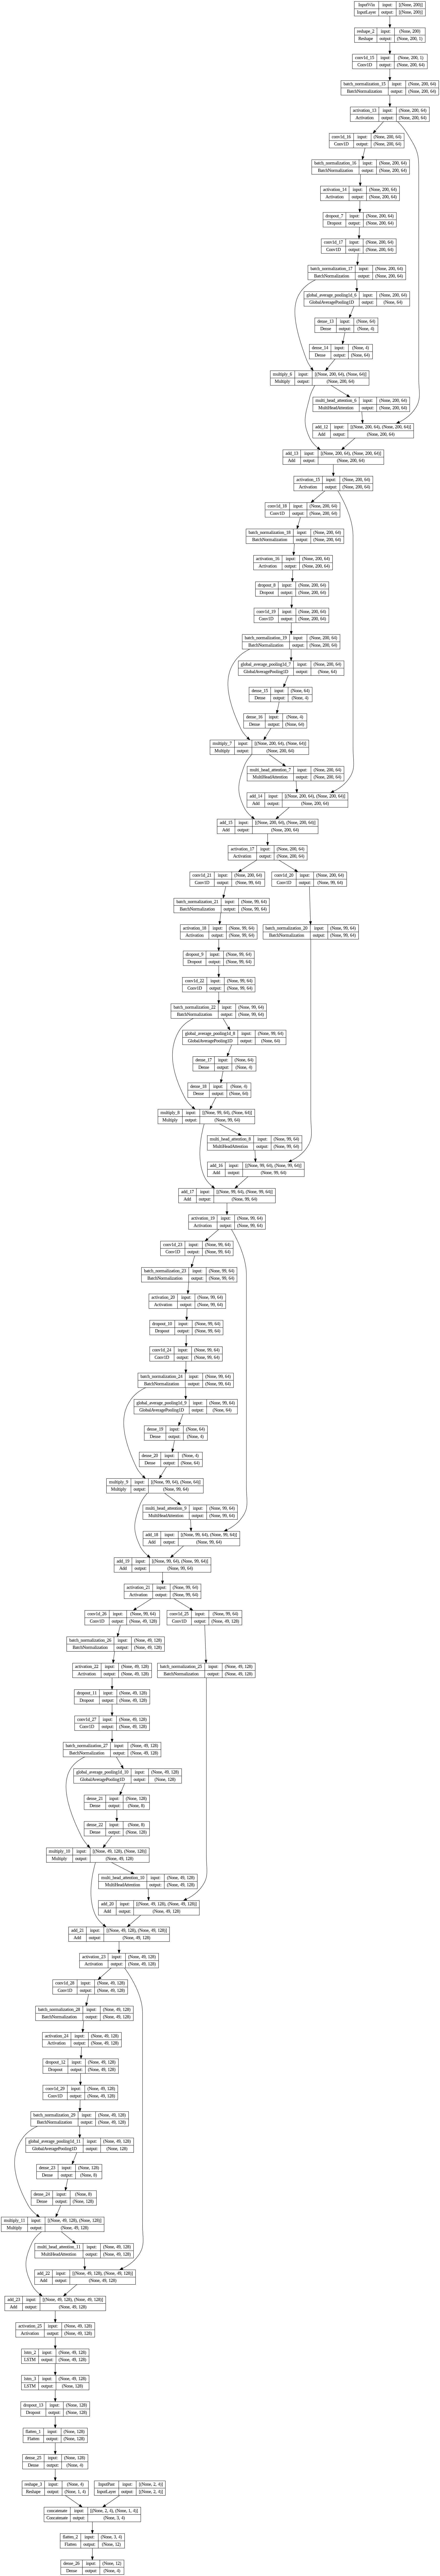

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

# Squeeze and excitation module
def se_block(in_block, channel, ratio=16):
    # Squeeze into single element per input filters
    squeeze = tfkl.GlobalAveragePooling1D()(in_block)

    # Compress these single elements into a lower nº of units (given by the ratio indicated)
    excitation = tfkl.Dense(channel // ratio, activation='relu')(squeeze)

    # Expand again the compressed elements into the input dimension: obtaining of a weight for each channel
    excitation = tfkl.Dense(channel, activation='sigmoid')(excitation)

    # Multiplication of each input filter with their corresponding weights
    scaled_input = tfkl.multiply([in_block, excitation])
    return scaled_input

# ResNet with Squeeze and excitation block model definition
def ResBs_SE_Conv_with_attention(block_input, num_filters=64, kernel_size=3):
    # Filter Block input and BatchNormalization
    block_input_short = tfkl.Conv1D(num_filters, kernel_size=kernel_size, strides=2, padding='valid')(block_input)
    block_input_short = tfkl.BatchNormalization()(block_input_short)

    # First Convolutional Layer
    conv1 = tfkl.Conv1D(filters=num_filters, kernel_size=kernel_size, strides=2, padding='valid')(block_input)
    norm1 = tfkl.BatchNormalization()(conv1)
    relu1 = tfkl.Activation('relu')(norm1)
    dropout = tfkl.Dropout(0.5)(relu1)

    # Second Convolutional Layer
    conv2 = tfkl.Conv1D(num_filters, kernel_size=kernel_size, padding='same')(dropout)
    norm2 = tfkl.BatchNormalization()(conv2)

    # SE block --> Channel attention layer
    se = se_block(norm2, channel=num_filters)

    # Self-Attention layer
    attention = tfkl.MultiHeadAttention(num_heads=1, key_dim=num_filters)(se, se, se)

    # Element-wise addition of the attention output and the original block_input
    block_input_short = tfkl.Add()([block_input_short, attention])

    # Summing Layer (adding a residual connection)
    sum = tfkl.Add()([block_input_short, se])

    # Activation Layer
    relu2 = tfkl.Activation('relu')(sum)

    return relu2

def ResBs_SE_Identity_with_attention(block_input, num_filters=64, kernel_size=3):
    # First Convolutional Layer
    conv1 = tfkl.Conv1D(filters=num_filters, kernel_size=kernel_size, padding='same')(block_input)
    norm1 = tfkl.BatchNormalization()(conv1)
    relu1 = tfkl.Activation('relu')(norm1)
    dropout = tfkl.Dropout(0.5)(relu1)

    # Second Convolutional Layer
    conv2 = tfkl.Conv1D(num_filters, kernel_size=kernel_size, padding='same')(dropout)
    norm2 = tfkl.BatchNormalization()(conv2)

    # SE block (function defined above)
    se = se_block(norm2, channel=num_filters)

    # Self-Attention layer
    attention = tfkl.MultiHeadAttention(num_heads=1, key_dim=num_filters)(se, se, se)

    # Element-wise addition of the attention output and the original block_input
    block_input = tfkl.Add()([block_input, attention])

    # Summing Layer (adding a residual connection)
    sum = tfkl.Add()([block_input, se])

    # Activation Layer
    relu2 = tfkl.Activation('relu')(sum)

    return relu2

def build_freq_model(inputwin_shape, inputpast_shape, classes, kernel_size, num_resnet_blocks, num_filters):


    inputwin_layer = tfkl.Input(shape=inputwin_shape, name='InputWin')
    inputpast_layer = tfkl.Input(shape=inputpast_shape, name='InputPast')

    # Build the model
    x = tfkl.Reshape((inputwin_shape[0], 1))(inputwin_layer)
    ResNet = tfkl.Conv1D(filters=64, kernel_size=kernel_size, padding='same')(x)
    ResNet = tfkl.BatchNormalization()(ResNet)
    ResNet = tfkl.Activation('relu')(ResNet)

    # B.5 ResBs blocks
    # First two ResNet blocks are identity blocks
    ResNet = ResBs_SE_Identity_with_attention(ResNet, num_filters=num_filters, kernel_size=kernel_size)
    ResNet = ResBs_SE_Identity_with_attention(ResNet, num_filters=num_filters, kernel_size=kernel_size)

    num_remaining_resnet_blocks = int((num_resnet_blocks - 2) / 2)
    for _ in range(num_remaining_resnet_blocks):
        # define N-th ResBs block
        ResNet = ResBs_SE_Conv_with_attention(ResNet, num_filters=num_filters, kernel_size=kernel_size)
        ResNet = ResBs_SE_Identity_with_attention(ResNet, num_filters=num_filters, kernel_size=kernel_size)
        num_filters *= 2

    # Apply LSTMs to better capture long-term dependencies and temporal relations in the sequential data
    ResNet = tfkl.LSTM(units=128, return_sequences=True)(ResNet)
    ResNet = tfkl.LSTM(units=128)(ResNet)
    ResNet = tfkl.Dropout(0.5)(ResNet)

     # Flatten and dense layers
    x = tfkl.Flatten()(ResNet)
    x = tfkl.Dense(classes, activation='relu')(x)

    # Concatenate with inputpast_layer
    x2 = tfkl.Reshape((1, 4))(x)
    xc = tfkl.Concatenate(axis=1)([inputpast_layer, x2])
    x = tfkl.Flatten()(xc)

    # Output layer with softmax activation
    output_layer = tfkl.Dense(classes, activation='softmax')(x)

    # Compile the model
    model = tf.keras.Model(inputs=[inputwin_layer, inputpast_layer], outputs=output_layer)
    return model


# Assuming XtrainW[0] and XtrainP[0] are your training data
freqmodel = build_freq_model(inputwin_shape=fXtrainW[0].shape, inputpast_shape=fXtrainP[0].shape, classes=4, kernel_size=3, num_resnet_blocks=6, num_filters=64)
freqmodel.summary()
tf.keras.utils.plot_model(freqmodel, show_shapes=True)

In [ ]:
BATCH_SIZE = 128
EPOCHS = 1000
LEARNING_RATE = 1e-3

freqmodel.compile(
    loss=tfk.losses.CategoricalCrossentropy(),
    optimizer=tfk.optimizers.Adam(learning_rate=LEARNING_RATE),
    metrics= 'accuracy'
)

# Define your learning rate schedule function
def lr_schedule(epoch, lr):
    if epoch < 10:
        return lr  # Use the initial learning rate for the first 10 epochs
    else:
        return lr * tf.math.exp(-0.1)  # Decay the learning rate exponentially

# Create a LearningRateScheduler callback
lr_scheduler = tfk.callbacks.LearningRateScheduler(lr_schedule)

# Add the LR callback to the list of callbacks
callbacks_list = [
    tfk.callbacks.EarlyStopping(monitor='accuracy', mode='max', patience=5),
    lr_scheduler
]

history = freqmodel.fit(
    x=[fXtrainW, fXtrainP],
    y=Ytrain,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    class_weight=CLASS_WEIGHT,
    validation_data=([fXvalW, fXvalP], fYval),
    callbacks=callbacks_list
).history

Epoch 1/1000


84/84 [==============================] - ETA: 0s - loss: 1.0503 - accuracy: 0.5321

84/84 [==============================] - 39s 91ms/step - loss: 1.0503 - accuracy: 0.5321 - val_loss: 0.9198 - val_accuracy: 0.6147 - lr: 0.0010
Epoch 2/1000
84/84 [==============================] - 6s 77ms/step - loss: 0.8213 - accuracy: 0.6801 - val_loss: 0.8119 - val_accuracy: 0.6847 - lr: 0.0010
Epoch 3/1000
84/84 [==============================] - 6s 68ms/step - loss: 0.6708 - accuracy: 0.7313 - val_loss: 0.6460 - val_accuracy: 0.7247 - lr: 0.0010
Epoch 4/1000
84/84 [==============================] - 6s 70ms/step - loss: 0.5519 - accuracy: 0.7738 - val_loss: 0.6243 - val_accuracy: 0.7447 - lr: 0.0010
Epoch 5/1000
84/84 [==============================] - 6s 71ms/step - loss: 0.4995 - accuracy: 0.7933 - val_loss: 0.4409 - val_accuracy: 0.8194 - lr: 0.0010
Epoch 6/1000
84/84 [==============================] - 6s 69ms/step - loss: 0.4577 - accuracy: 0.8124 - val_loss: 0.4974 - val_accuracy: 0.7997 - lr: 0.0010
Epoch 7/1000
84/84 [==============================] - 7s 78ms/step - loss: 0

TRAINING HISTORY


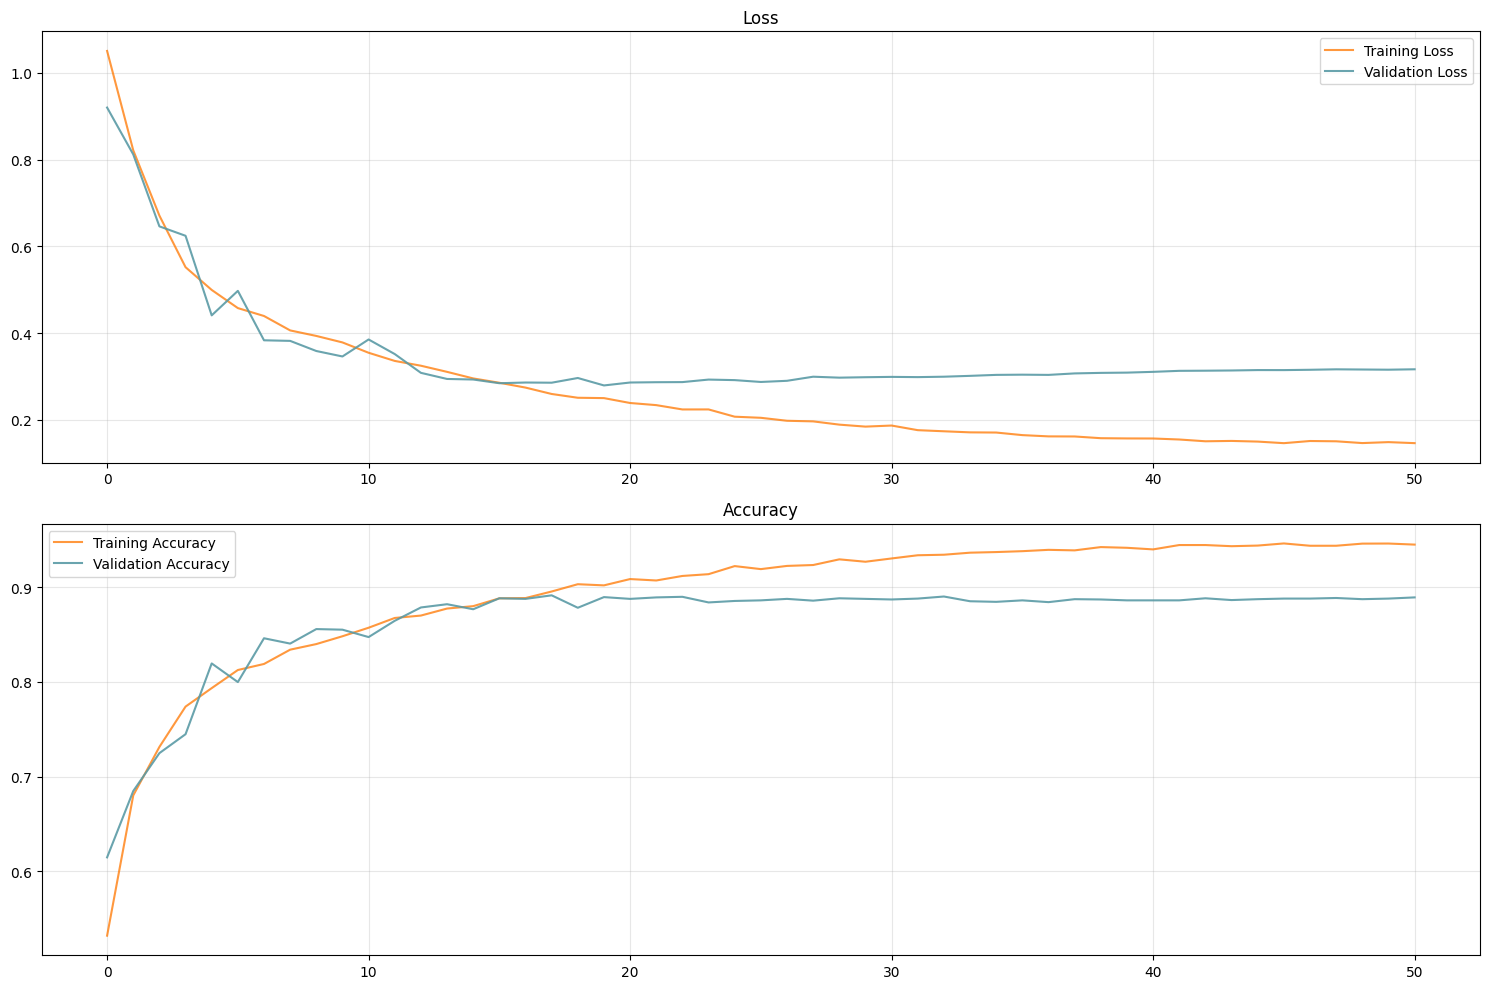

In [ ]:
print("TRAINING HISTORY")
plt.figure(figsize=(15, 10))

# Plot Training and Validation Loss
plt.subplot(2, 1, 1)
plt.plot(history['loss'], label='Training Loss', alpha=0.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation Loss', alpha=0.9, color='#5a9aa5')
plt.title('Loss')
plt.legend()
plt.grid(alpha=0.3)

# Plot Training and Validation Accuracy
plt.subplot(2, 1, 2)
plt.plot(history['accuracy'], label='Training Accuracy', alpha=0.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation Accuracy', alpha=0.9, color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
preds = np.argmax(freqmodel.predict([fXtestW, fXtestP]), axis=1)
Ytestt = np.argmax(Ytest, axis=1)
corrects = preds == Ytestt
print("ACCURACY: ", np.count_nonzero(corrects) / corrects.shape[0])

43/43 [==============================] - 2s 14ms/step
ACCURACY:  0.8717201166180758


CONFUSION MATRIX
[[412  20  26]
 [ 15 383  59]
 [ 12  44 401]]


              precision    recall  f1-score   support

           0       0.94      0.90      0.92       458
           1       0.86      0.84      0.85       457
           2       0.83      0.88      0.85       457

    accuracy                           0.87      1372
   macro avg       0.87      0.87      0.87      1372
weighted avg       0.87      0.87      0.87      1372



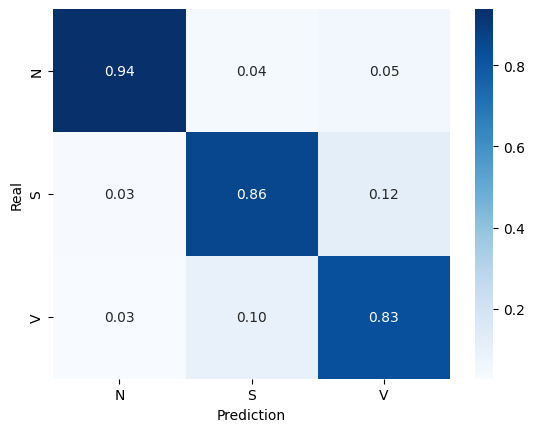

In [ ]:
print("CONFUSION MATRIX")
print(sklearn.metrics.confusion_matrix(Ytestt,preds))
print()
print()
print(sklearn.metrics.classification_report(Ytestt,preds))

cmf = sklearn.metrics.confusion_matrix(Ytestt,preds)/np.sum(sklearn.metrics.confusion_matrix(Ytestt,preds),axis=0)
hm=sns.heatmap(cmf,annot=True,fmt=".2f",cmap="Blues")
hm.set_xticklabels(['N','S','V'])
hm.set_xlabel("Prediction")
hm.set_ylabel("Real")
hm.set_yticklabels(['N','S','V'])
plt.show()

In [ ]:
import os
from datetime import datetime
from tensorflow.keras.models import save_model

# Save the model
time_stamp = datetime.now().strftime("%Y%m%d_%H%M")
freqmodel_folder = '/gdrive/MyDrive/AI_project/models/freq_models'
freqmodel_name = f"freq_model_{time_stamp}_task2_freddy"  # Add additional info if needed

# Assuming timemodel is your model
save_model(freqmodel, os.path.join(freqmodel_folder, f"{freqmodel_name}.h5"))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bo

#### Reload the models (use only if you want to evaluate another model, otherwise skip)

In [ ]:
#Load TIME Model
time_model_file_path = '/gdrive/MyDrive/AI_project/models/time_models/time_model_20231227_1307_newPreprocessing_undersampling_BALANCED_FINAL_TASK2_seed.h5'
timemodel = tfk.models.load_model(time_model_file_path)

timemodel.summary()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 InputWin (InputLayer)       [(None, 200)]                0         []                            
                                                                                                  
 reshape_8 (Reshape)         (None, 200, 1)               0         ['InputWin[0][0]']            
                                                                                                  
 lstm_8 (LSTM)               (None, 200, 128)             66560     ['reshape_8[0][0]']           
                                                                                                  
 conv1d_5 (Conv1D)           (None, 200, 64)              24640     ['lstm_8[0][0]']              
                                                                                            

In [ ]:
#Load FREQ Model
freq_model_file_path = '/gdrive/MyDrive/AI_project/models/freq_models/freq_model_20231227_1313_newPreprocessing_undersampling_BALANCED_TASK2_FINAL_seed.h5'
freq_model = tfk.models.load_model(freq_model_file_path)

freq_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 InputWin (InputLayer)       [(None, 200)]                0         []                            
                                                                                                  
 reshape_10 (Reshape)        (None, 200, 1)               0         ['InputWin[0][0]']            
                                                                                                  
 lstm_10 (LSTM)              (None, 200, 128)             66560     ['reshape_10[0][0]']          
                                                                                                  
 conv1d_6 (Conv1D)           (None, 200, 64)              24640     ['lstm_10[0][0]']             
                                                                                            

#### Ensemble 1: Argmax

In [ ]:
def ensemble_predict(model1_preds, model2_preds):
    # Combine predictions by summing
    combined_preds = model1_preds + model2_preds

    # Take argmax to get final predictions
    final_preds = np.argmax(combined_preds, axis=1)

    return final_preds

# Assuming you have time_model and freq_model already trained and XtestW_scaled, XtestP prepared
#time_preds = time_model.predict([XtestW_scaled, XtestP])
#freq_preds = freq_model.predict([np.fft.fft(XtestW, axis=1), XtestP])

time_preds = timemodel.predict([XtestW, XtestP])
freq_preds = freqmodel.predict([fXtestW, fXtestP])

# Use the ensemble function
ensemble_preds = ensemble_predict(time_preds, freq_preds)

# Evaluate the ensemble predictions
Ytestt = np.argmax(Ytest, axis=1)
corrects = ensemble_preds == Ytestt

print("Accuracy: ", np.count_nonzero(corrects) / corrects.shape[0])
print(sklearn.metrics.confusion_matrix(Ytestt, ensemble_preds))
print()
print(sklearn.metrics.classification_report(Ytestt, ensemble_preds))

43/43 [==============================] - 0s 8ms/step
Accuracy:  0.8957725947521866
[[420  10  28]
 [  8 399  50]
 [ 11  36 410]]

              precision    recall  f1-score   support

           0       0.96      0.92      0.94       458
           1       0.90      0.87      0.88       457
           2       0.84      0.90      0.87       457

    accuracy                           0.90      1372
   macro avg       0.90      0.90      0.90      1372
weighted avg       0.90      0.90      0.90      1372



#### Ensemble 2: Averaging

In [ ]:
def average_ensemble_predict(model1_preds, model2_preds):
    # Average predictions
    averaged_preds = (model1_preds + model2_preds) / 2.0

    # Take argmax to get final predictions
    final_preds = np.argmax(averaged_preds, axis=1)

    return final_preds

# Assuming you have time_model and freq_model already trained and XtestW_scaled, XtestP prepared
time_preds = timemodel.predict([XtestW, XtestP])
freq_preds = freqmodel.predict([np.fft.fft(XtestW, axis=1), XtestP])

# Use the averaging ensemble function
ensemble_preds = average_ensemble_predict(time_preds, freq_preds)

# Evaluate the ensemble predictions
Ytestt = np.argmax(Ytest, axis=1)
corrects = ensemble_preds == Ytestt

print("Accuracy: ", np.count_nonzero(corrects) / corrects.shape[0])
print(sklearn.metrics.confusion_matrix(Ytestt, ensemble_preds))
print()
print(sklearn.metrics.classification_report(Ytestt, ensemble_preds))

43/43 [==============================] - 1s 12ms/step
Accuracy:  0.8957725947521866
[[420  10  28]
 [  8 399  50]
 [ 11  36 410]]

              precision    recall  f1-score   support

           0       0.96      0.92      0.94       458
           1       0.90      0.87      0.88       457
           2       0.84      0.90      0.87       457

    accuracy                           0.90      1372
   macro avg       0.90      0.90      0.90      1372
weighted avg       0.90      0.90      0.90      1372



#### Final label prediction

43/43 [==============================] - 0s 8ms/step
ACCURAY:  0.8957725947521866
[[420  10  28]
 [  8 399  50]
 [ 11  36 410]]


              precision    recall  f1-score   support

           0       0.96      0.92      0.94       458
           1       0.90      0.87      0.88       457
           2       0.84      0.90      0.87       457

    accuracy                           0.90      1372
   macro avg       0.90      0.90      0.90      1372
weighted avg       0.90      0.90      0.90      1372



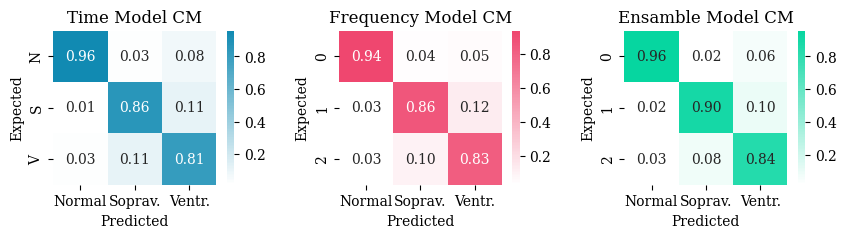

In [ ]:
timepreds = timemodel.predict([XtestW, XtestP])
freqpreds = freqmodel.predict([np.fft.fft(XtestW,axis=1), XtestP])
preds = np.argmax(timepreds+freqpreds,axis=1)

# Evaluate the ensemble predictions
Ytestt = np.argmax(Ytest,axis=1)
corrects = preds==Ytestt
print("ACCURAY: ",np.count_nonzero(corrects)/corrects.shape[0])

print(sklearn.metrics.confusion_matrix(Ytestt,preds))
print()
print()
print(sklearn.metrics.classification_report(Ytestt,preds))

cm = sklearn.metrics.confusion_matrix(Ytestt,preds)/np.sum(sklearn.metrics.confusion_matrix(Ytestt,preds),axis=0)


colors = ((1,1,1),(10/255, 95/255, 200/255))
cmapp = LinearSegmentedColormap.from_list('cmapp', colors, N=100)

plt.figure(figsize=(10,2))
plt.subplot(1,3,1)
hm=sns.heatmap(cmt,annot=True,cmap=cmapp)
hm.set_xticklabels(['N','S','V'])
hm.set_xlabel("Predicted")
hm.set_ylabel("Expected")
hm.set_yticklabels(['N','S','V'])
plt.title("Time Model CM")

from matplotlib.colors import LinearSegmentedColormap
colors = ((1,1,1),(239/255, 71/255, 111/255))
cmapp = LinearSegmentedColormap.from_list('cmapp', colors, N=100)


plt.subplot(1,3,2)
hm=sns.heatmap(cmf,annot=True,fmt=".2f",cmap=cmapp)
hm.set_xticklabels(['N','S','V'])
hm.set_xlabel("Predicted")
hm.set_ylabel("Expected")
plt.title("Frequency Model")

from matplotlib.colors import LinearSegmentedColormap
colors = ((1,1,1),(6/255, 214/255, 160/255))
cmapp = LinearSegmentedColormap.from_list('cmapp', colors, N=100)

plt.subplot(1,3,3)
hm=sns.heatmap(cm,annot=True,fmt=".2f",cmap=cmapp)
hm.set_xticklabels(['Normal','Soprav.','Ventr.'])
hm.set_xlabel("Predicted")
hm.set_ylabel("Expected")
plt.title("Ensemble Model")

plt.subplots_adjust(wspace=0.4, hspace=0)
plt.show()

## **4** Testing the models

In [ ]:
dataset_path = '/gdrive/MyDrive/AI_project/test_126'

In [ ]:
files = sorted(os.listdir(dataset_path))
print(files)

['S126_250.mat', 'S126_250_spk.mat']


In [ ]:
correct = 0
incorrect = 0
nans = 0

patient = []

for f in range(0,len(files),2):
  try:
    ppg = loadmat(os.path.join(dataset_path,files[f]))
    #ann = loadmat(os.path.join(dataset_path,files[f+1]))
    spk = loadmat(os.path.join(dataset_path,files[f+1]))
    patient_dict={
            'ID':files[f].split("_")[0],
            'path':os.path.join("test_students",files[f]),
            'fs':float(files[f].split(".")[0].split("_")[1]),
            'samples':ppg['ppg'][:,0].shape[0],
            'ppg':ppg['ppg'][:,0],
            'speaks':spk['speaks'].T[0], #speaks vector transpose
            'peak_labels': []
    }
    patient.append(Patient(patient_dict))
    nans += patient[-1].countnans()
    correct+=1
  except:
    incorrect +=1

print(f"Loaded {correct} files correctly")
if incorrect>0: print(f"!!!! Error in loading {incorrect} files")
if nans>0: print("Found: ",nans, "missing values")

Loaded 1 files correctly


In [ ]:
patient[3].info()

IndexError: list index out of range

In [ ]:
patient[3].plot()

In [ ]:
for f in range(0, min(5, len(files)), 2):  # Adjusted to print the first 5 files
    try:
        ppg = loadmat(os.path.join(dataset_path, files[f]))
        spk = loadmat(os.path.join(dataset_path, files[f+1]))

        # Print contents of 'ppg' and 'speaks'
        print(f"\nFile {files[f]}:")
        print(f"ppg: {ppg['ppg'][:, 0]}")
        print(f"speaks: {spk['speaks'].T[0]}")
    except Exception as e:
        print(f"Error loading file {files[f]}: {e}")



File S126_250.mat:
ppg: [-1.89403918 -1.89403914 -1.89403909 ... 34.94304113 34.0891301
 33.92879725]
speaks: [     282      558      842 ... 20711453 20711752 20712053]


In [ ]:
fs = 128
lowcut = 0.5
highcut = 5.0

for p in patient:
  p.butter_bandpassfilter(lowcut, highcut, fs, 3)

In [ ]:
for p in patient:
  p.z_score_normalize_signal()

### Task 1

In [ ]:
#Load TIME Model
time_model_file_path = '/gdrive/MyDrive/AI_project/models/time_models/time_model_20240106_0925_test.h5'
timemodel_t1 = tfk.models.load_model(time_model_file_path)

timemodel_t1.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 InputWin (InputLayer)       [(None, 200)]                0         []                            
                                                                                                  
 reshape_4 (Reshape)         (None, 200, 1)               0         ['InputWin[0][0]']            
                                                                                                  
 lstm_4 (LSTM)               (None, 200, 256)             264192    ['reshape_4[0][0]']           
                                                                                                  
 conv1d_4 (Conv1D)           (None, 200, 128)             163968    ['lstm_4[0][0]']              
                                                                                            

In [ ]:
#Load FREQ Model
freq_model_file_path = '/gdrive/MyDrive/AI_project/models/freq_models/freq_model_20240106_0930_test.h5'
freqmodel_t1 = tfk.models.load_model(freq_model_file_path)

freqmodel_t1.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 InputWin (InputLayer)       [(None, 200)]                0         []                            
                                                                                                  
 reshape_6 (Reshape)         (None, 200, 1)               0         ['InputWin[0][0]']            
                                                                                                  
 conv1d_6 (Conv1D)           (None, 200, 64)              256       ['reshape_6[0][0]']           
                                                                                                  
 batch_normalization_6 (Bat  (None, 200, 64)              256       ['conv1d_6[0][0]']            
 chNormalization)                                                                           

In [ ]:
def build_dataset_for_patient(patient, width=200):
    X_Win = []
    X_Past = []

    # Split the patient's peaks with specified parameters
    split = patient.split_peaks(borders=0.05, fixed_length=width)

    # Randomly shuffle indices for processing in a random order
    vect = np.arange(0, len(split))
    np.random.shuffle(vect)
    for i in range(0, len(vect)):
      X_Win.append(np.array(split[i]))
      X_Past.append([[0,0,0],[0,0,0]])
    return np.array(X_Win), np.array(X_Past)

In [ ]:
(X_W, X_P) = build_dataset_for_patient(patient[0], 200)

windows: 76584


In [ ]:
def ensemble_predict(model1_preds, model2_preds):
    # Combine predictions by summing
    combined_preds = model1_preds + model2_preds

    # Take argmax to get final predictions
    final_preds = np.argmax(combined_preds, axis=1)

    return final_preds

In [ ]:
cd /gdrive/MyDrive/AI_project/annotation_task1/

/gdrive/.shortcut-targets-by-id/1LW5cvzLJtFof8UyS6SsCDPPzuiheZpd0/AI_project/annotation_task1


In [ ]:
import os
from scipy.io import savemat
for i in range(0,len(patient)):
  file_path = patient[i].path
  file_name = os.path.splitext(os.path.basename(file_path))[0]
  # Build dataset for the chosen patient
  (X_W, X_P) = build_dataset_for_patient(patient[i], 200)
  timepred = timemodel_t1.predict([X_W, X_P])

  for j in range(2,len(timepred)):
        X_P[j-2][0] = timepred[j]
        X_P[j-2][1] = timepred[j]

  timepred = timemodel_t1.predict([X_W, X_P])

  fX_W = np.fft.fft(X_W)
  freqpred = freqmodel_t1.predict([fX_W, X_P])
  # Use the ensemble function
  ensemble_preds = ensemble_predict(timepred, freqpred)
  # Create a vector of chars based on ensemble_preds
  pred = ['N' if label == 0 else 'A' for label in ensemble_preds]

  # Convert the list to a numpy array if needed
  pred = np.array(pred)

  # Save the char vector to a .mat file
  mat_file_name = file_name + '_ann.mat'
  savemat(mat_file_name, {'labels': pred})

  print(f"Saved char vector to {mat_file_name}")

windows: 76584
2394/2394 [==============================] - 22s 9ms/step


2394/2394 [==============================] - 25s 9ms/step
Saved char vector to S126_250_ann.mat


### Task 2

In [ ]:
#Load TIME Model
time_model_file_path = '/gdrive/MyDrive/AI_project/models/time_models/time_model_20240106_0936_test_task2.h5'
timemodel_t2 = tfk.models.load_model(time_model_file_path)

timemodel_t2.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 InputWin (InputLayer)       [(None, 200)]                0         []                            
                                                                                                  
 reshape_8 (Reshape)         (None, 200, 1)               0         ['InputWin[0][0]']            
                                                                                                  
 lstm_8 (LSTM)               (None, 200, 256)             264192    ['reshape_8[0][0]']           
                                                                                                  
 conv1d_21 (Conv1D)          (None, 200, 128)             163968    ['lstm_8[0][0]']              
                                                                                            

In [ ]:
#Load FREQ Model
freq_model_file_path = '/gdrive/MyDrive/AI_project/models/freq_models/freq_model_20240106_0940_test_task2.h5'
freqmodel_t2 = tfk.models.load_model(freq_model_file_path)

freqmodel_t2.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 InputWin (InputLayer)       [(None, 200)]                0         []                            
                                                                                                  
 reshape_10 (Reshape)        (None, 200, 1)               0         ['InputWin[0][0]']            
                                                                                                  
 conv1d_23 (Conv1D)          (None, 200, 64)              256       ['reshape_10[0][0]']          
                                                                                                  
 batch_normalization_23 (Ba  (None, 200, 64)              256       ['conv1d_23[0][0]']           
 tchNormalization)                                                                          

In [ ]:
def build_dataset_for_patient(patient, width=200):
    X_Win = []
    X_Past = []

    # Split the patient's peaks with specified parameters
    split = patient.split_peaks(borders=0.05, fixed_length=width)

    # Randomly shuffle indices for processing in a random order
    vect = np.arange(0, len(split))
    np.random.shuffle(vect)
    for i in range(0, len(vect)):
      X_Win.append(np.array(split[i]))
      X_Past.append([[0,0,0,0],[0,0,0,0]])
    return np.array(X_Win), np.array(X_Past)

In [ ]:
def ensemble_predict(model1_preds, model2_preds):
    # Combine predictions by summing
    combined_preds = model1_preds + model2_preds

    # Take argmax to get final predictions
    final_preds = np.argmax(combined_preds, axis=1)

    return final_preds

In [ ]:
cd /gdrive/MyDrive/AI_project/annotation126/

/gdrive/.shortcut-targets-by-id/1LW5cvzLJtFof8UyS6SsCDPPzuiheZpd0/AI_project/annotation126


In [ ]:
import os
from scipy.io import savemat
for i in range(0,len(patient)):
  file_path = patient[i].path
  file_name = os.path.splitext(os.path.basename(file_path))[0]
  # Build dataset for the chosen patient
  (X_W, X_P) = build_dataset_for_patient(patient[i], 200)
  timepred = timemodel_t2.predict([X_W, X_P])

  for j in range(2,len(timepred)):
        X_P[j-2][0] = timepred[j]
        X_P[j-2][1] = timepred[j]

  timepred = timemodel_t2.predict([X_W, X_P])

  fX_W = np.fft.fft(X_W)
  freqpred = freqmodel_t2.predict([fX_W, X_P])
  # Use the ensemble function
  ensemble_preds = ensemble_predict(timepred, freqpred)
  # Create a vector of chars based on ensemble_preds
  pred = ['N' if label == 0 else 'S' if label == 1 else 'V' for label in ensemble_preds]

  # Convert the list to a numpy array if needed
  pred = np.array(pred)

  # Save the char vector to a .mat file
  mat_file_name = file_name + '_ann.mat'
  savemat(mat_file_name, {'labels': pred})

  print(f"Saved char vector to {mat_file_name}")

windows: 76584
2394/2394 [==============================] - 21s 9ms/step


2394/2394 [==============================] - 24s 10ms/step
Saved char vector to S126_250_ann.mat
